Give a go at building a very basic autoencoder to reconstruct spectra.  Then see if the latent parameters are useful at separating any physical properties of the quasars.

Note that a *Variational* autoencoder is what we want to end up at.  The encoder would return latent *distributions* in the latent space; instead of simply reducing the spectra to say 6 latent values, it would return a "latent mean" and "latent variance" for each dimension in latent space.  Then, the decoder would randomly draw from each of these distributions to reconstruct the spectra.  Thus, a variational autoencoder is non-deterministic.

In [1]:
from tensorflow import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [2]:
#Load the metadata of all 8403 objects
dat = pd.read_csv("../data/grdr7.8403col.radec.platemjdfiber.csv")
dat.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET      MI_Z2    LOGLBOL  ...  LOGL_MGII    EW_MGII  \
0  51608               0 -27.635967  47.094489  ...  44.376721  26.967853   
1  51633               0 -26.986037  46.849020  ...  44.163982  28.819893   
2  51909               0 -27.539811  47.031922  ...  44.413369  34.569696   
3  51909               0 -26.907112  46.713170  ...  43.993350  26.541603   
4  51883               0 -27.177639  46.782514  ...  44.111600  29.946692   

   LOGL_BROAD_MGII  EW_BROAD_MGII   LOGL_CIV     EW_CIV  VOFF_CIV_PEAK  \
0        44.366029      26.312016  44.901087  36.111955     712.104035   
1        44.132085      26.779087  44.658484  32.642452     305.754876   
2        44.408935      34.218546  44.929561  56.727337     -26.149363   
3        43.989344      26.297896  44.421090  25.101699    1000.490718   
4        44.104876      29.486556  44.499160  28.892388     530.384452   

   LOGEDD_RATIO      Z_HW      E_BV  
0     -0.494012  1.779394  0.069739  
1     -0.837157  1.882529  0.035407  
2     -0.780922  1.668503  0.044319  
3     -0.337591  1.750491  0.031931  
4     -0.564674  1.823599  0.048818  

[5 rows x 25 columns]

In [3]:
z     = dat[["REDSHIFT_1"]].values.flatten()
plate = dat[["PLATE_1"]].values.flatten()
mjd   = dat[["MJD_1"]].values.flatten()
fiber = dat[["FIBER_1"]].values.flatten()

This cell can take a while.

In [357]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
spectra = np.array([])
wave    = np.array([])
ivar    = np.array([])
found   = np.array([]) #save dataframe indices which have spectra
N = 0

for red, pl, mj, fib in zip(z, plate, mjd, fiber):
    try:
        hdul_spec = fits.open("../data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        print("../data/VLAspectra_all8403/lite/%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>1470) & (sdss_wave<2875))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(spectra) < 1:
        spectra = np.append(spectra, sdss_flux)
        wave = np.append(wave, sdss_wave)
        ivar = np.append(ivar, sdss_ivar)
        found = np.append(found, N)
    else:
        if len(sdss_flux) >= 2913:
            spectra = np.vstack((spectra, sdss_flux[:2913])) #Some might have one extra pixel
            wave = np.vstack((wave, sdss_wave[:2913]))
            ivar = np.vstack((ivar, sdss_ivar[:2913]))
            found = np.vstack((found, N))
    N+=1
    #if N>1000: break #Just because this cell takes a while to run and we don't need all spectra since we're not deriving our own components 

../data/VLAspectra_all8403/lite/2516/spec-2516-54240-0119.fits NOT FOUND
../data/VLAspectra_all8403/lite/2516/spec-2516-54240-0125.fits NOT FOUND
../data/VLAspectra_all8403/lite/2256/spec-2256-53859-0031.fits NOT FOUND


----

Now build the autoencoder.  See Chapter 17 of Geron, Hands-on Machine Learning...

In [6]:
spectra[0].shape

(2913,)

In [368]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=spectra[0].shape),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(10, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[10]),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.Dense(spectra[0].shape[0]) #no activation function since we want actual pixel values
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [374]:
stacked_ae.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(lr=1e-5, beta_1=0.9, beta_2=0.999))

In [1]:
X_train = spectra[:5000]
X_valid = spectra[5000:7000]
X_test  = spectra[7000:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

NameError: name 'spectra' is not defined

Note: This wasn't the only round of training.  Want to start with higher learning rate then slowly decrease.

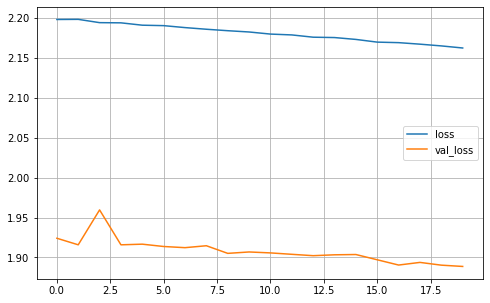

In [377]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [378]:
reconst = stacked_ae.predict(np.array([X_valid[0]]))

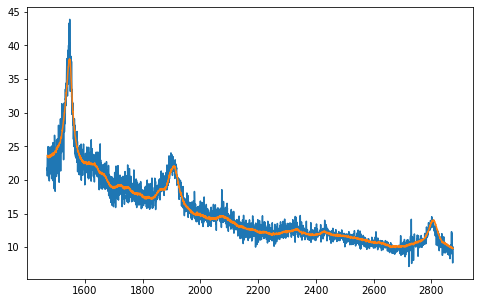

In [379]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[6000], X_valid[0])
plt.plot(wave[6000], reconst[0])
plt.show()

In [457]:
n_spectra = 100
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

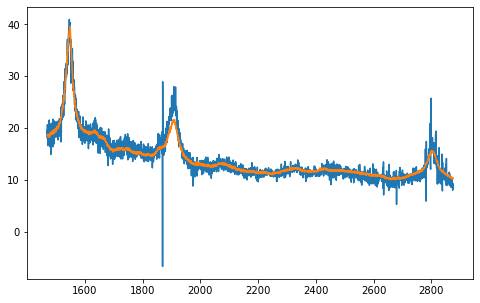

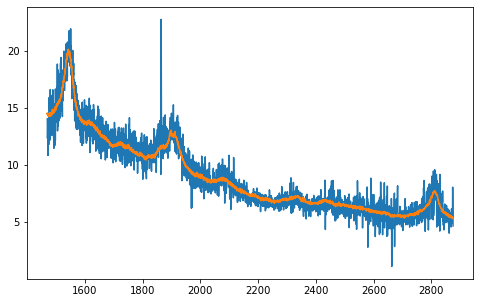

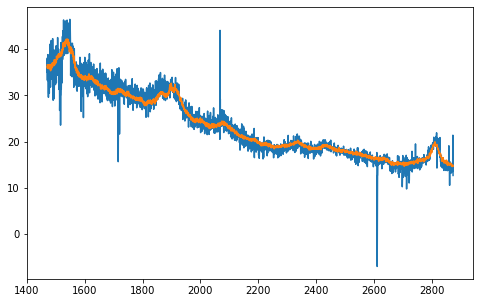

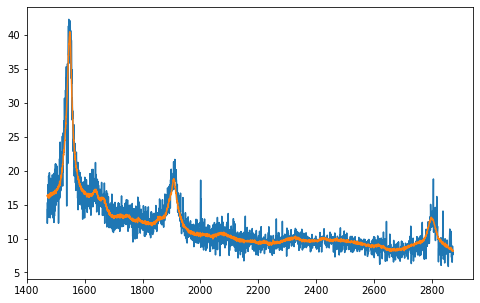

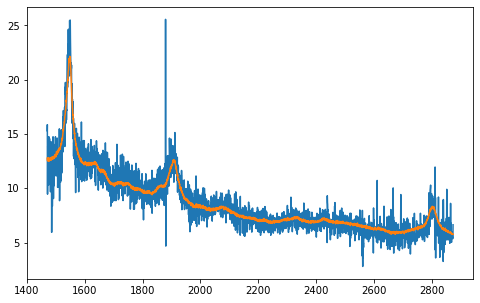

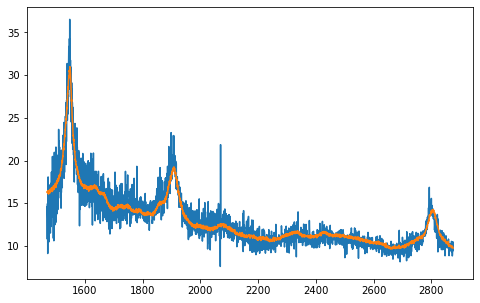

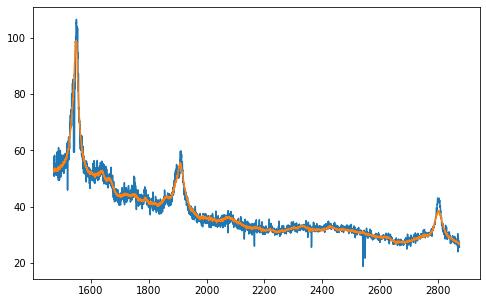

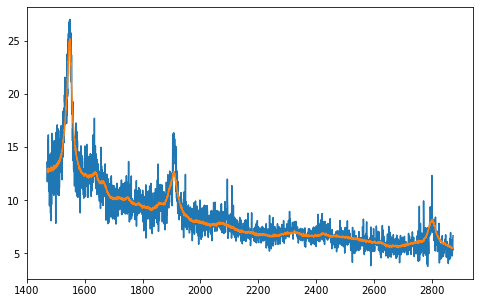

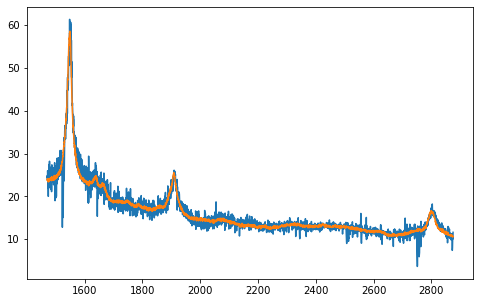

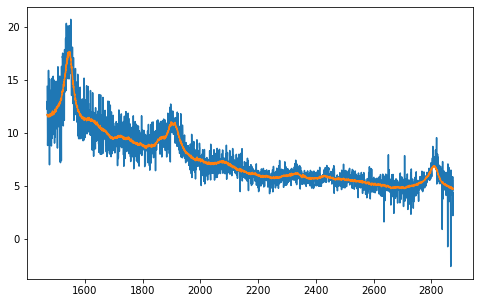

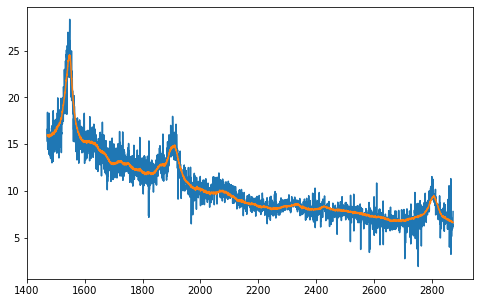

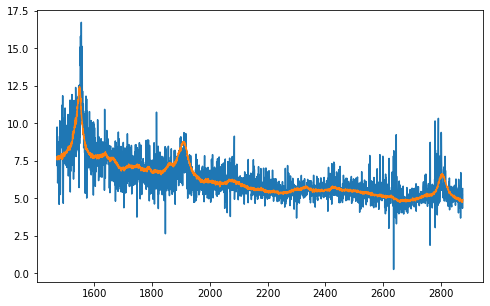

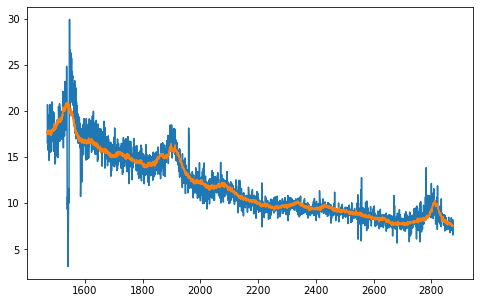

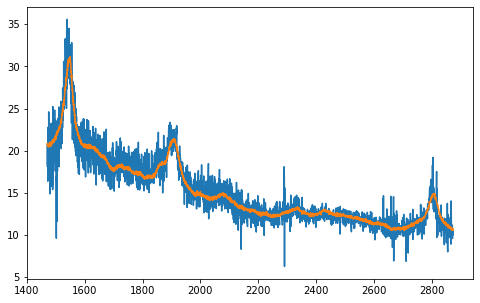

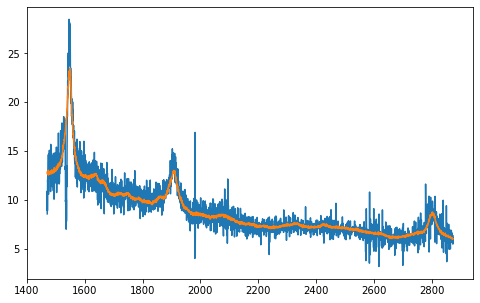

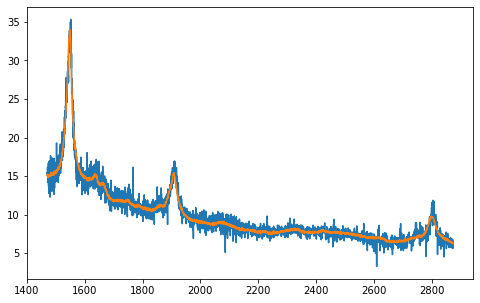

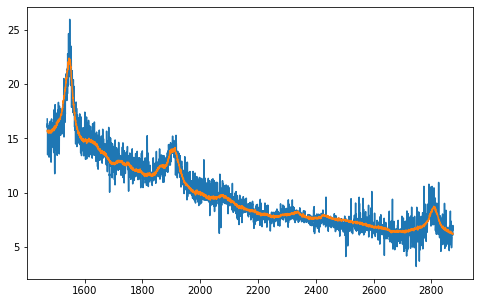

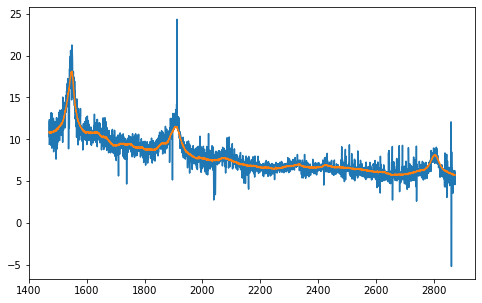

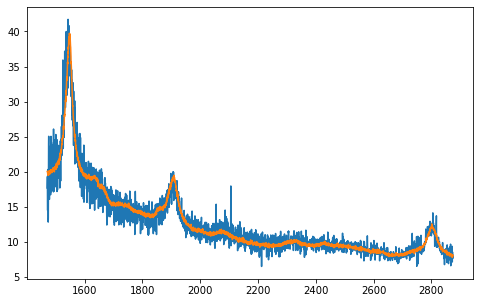

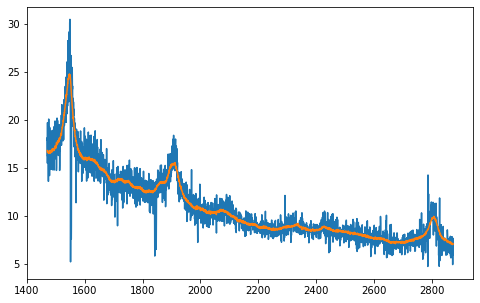

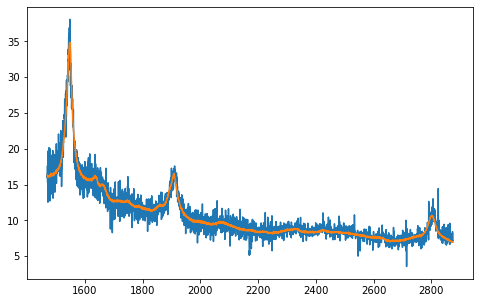

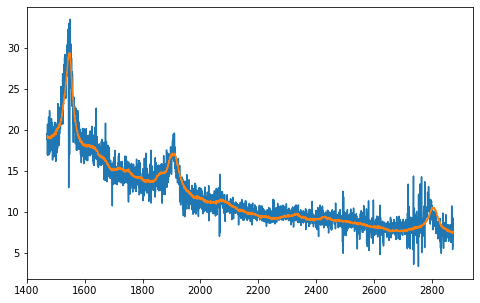

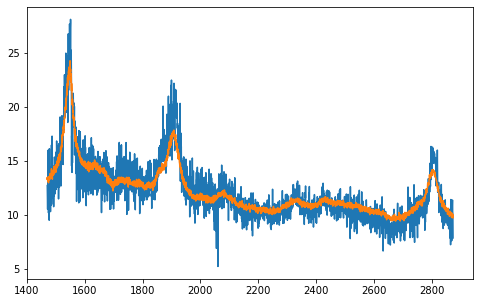

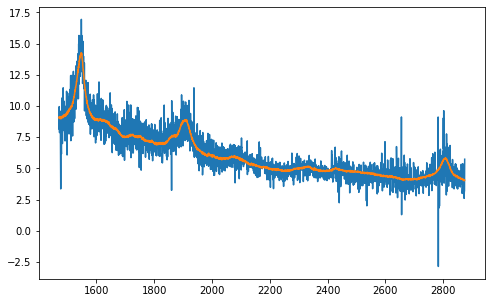

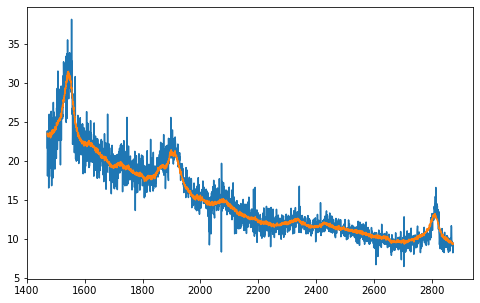

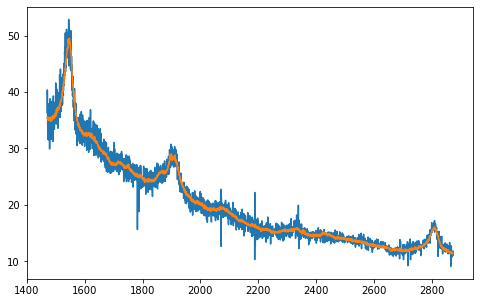

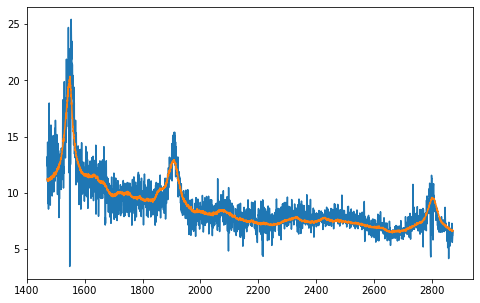

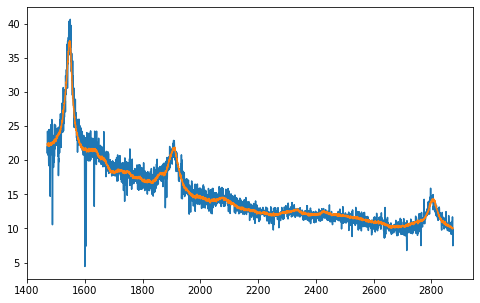

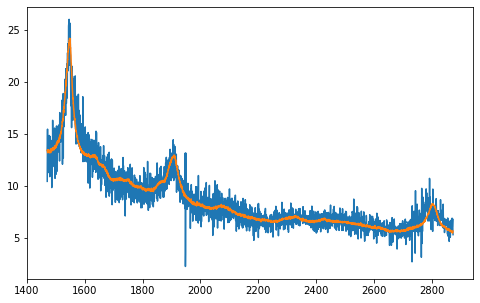

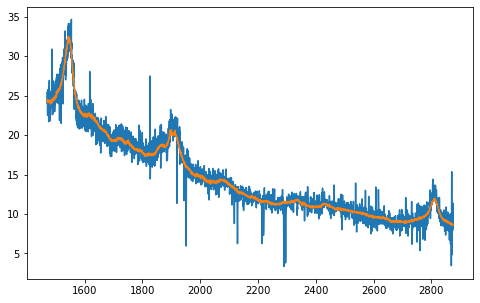

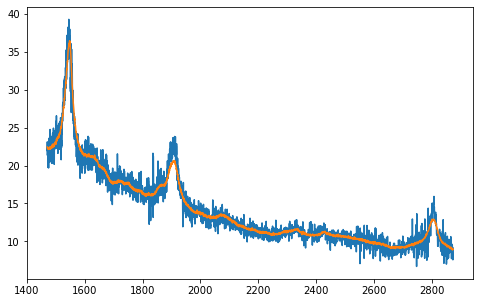

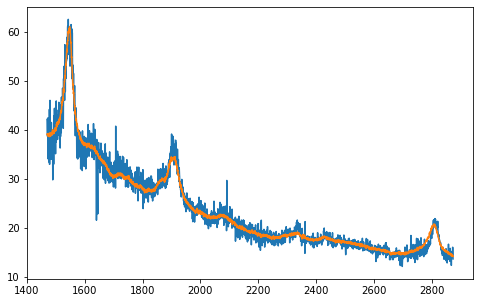

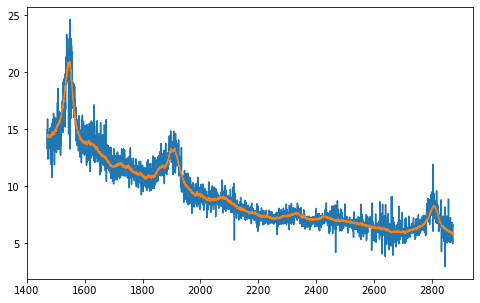

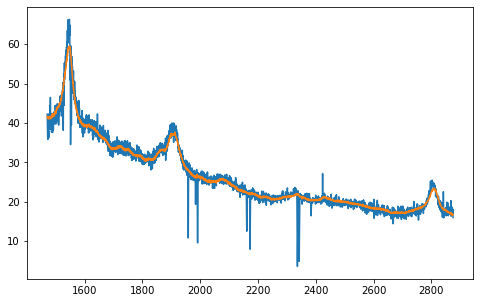

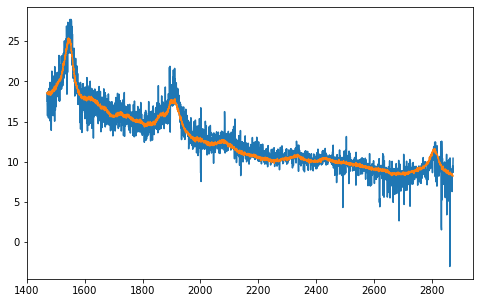

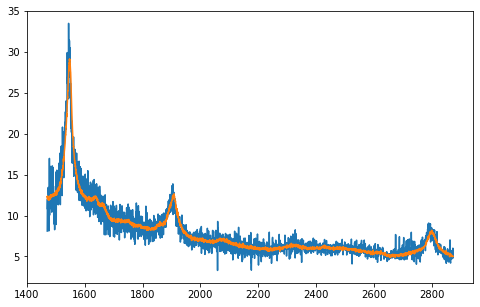

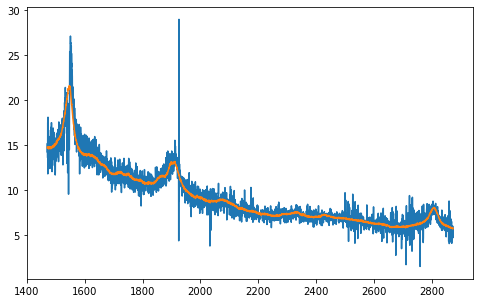

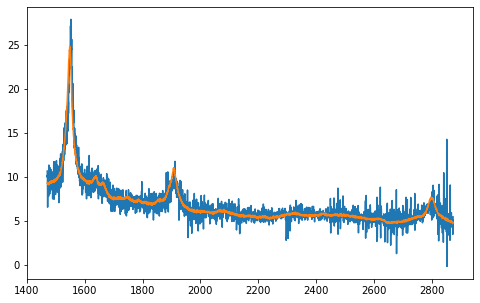

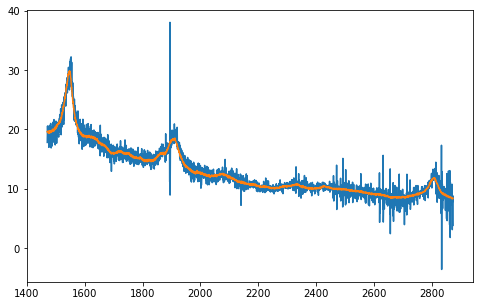

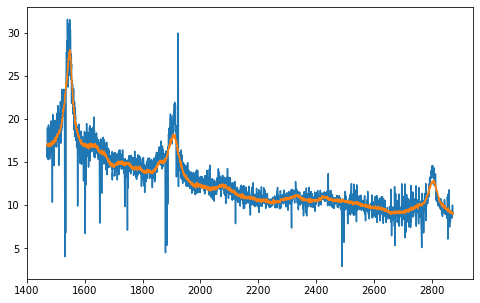

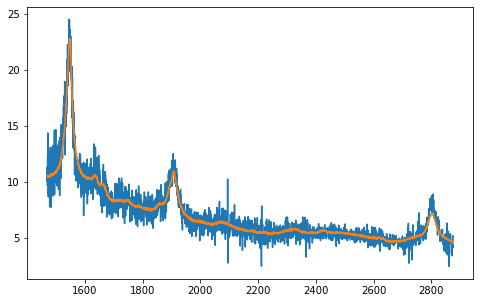

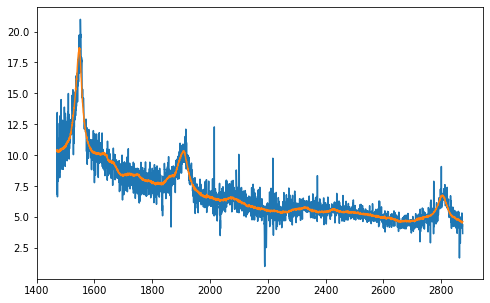

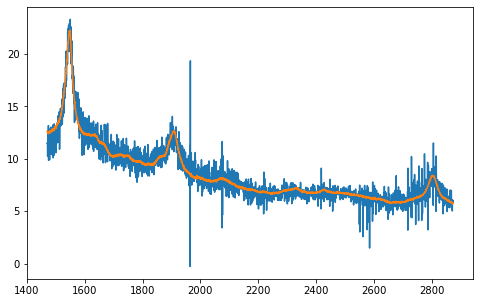

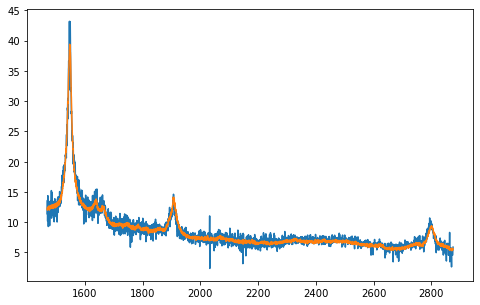

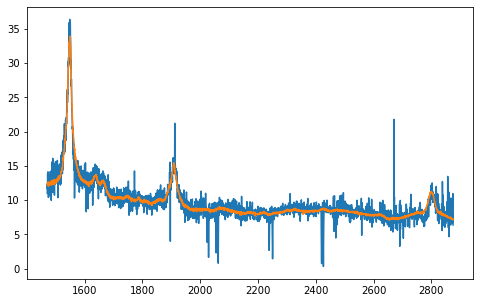

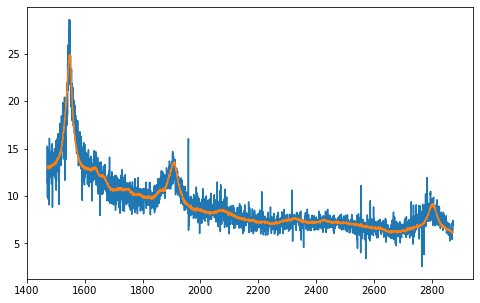

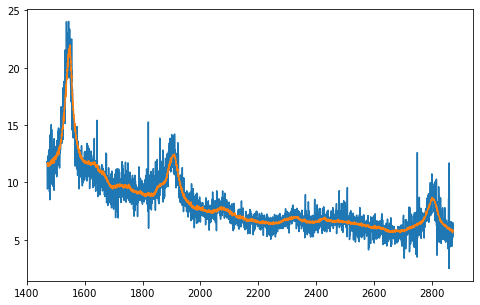

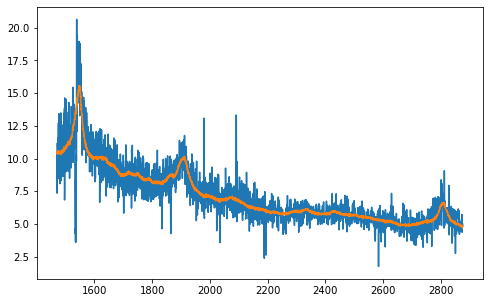

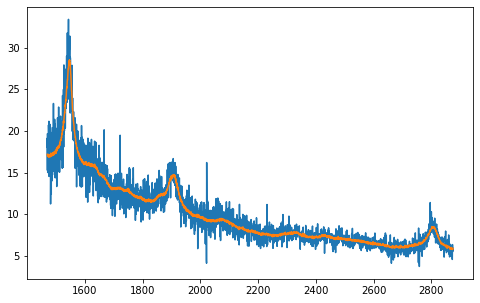

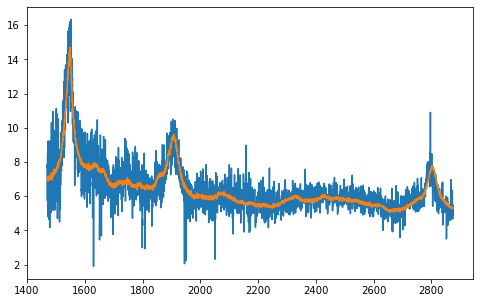

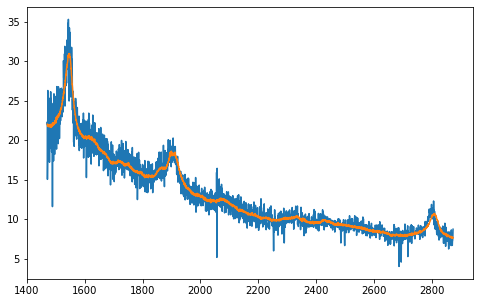

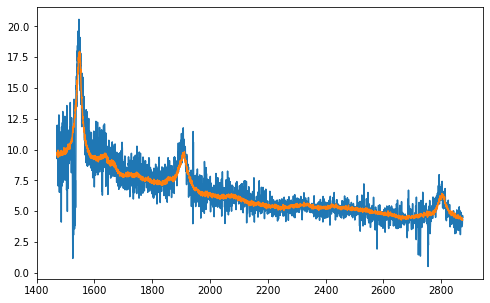

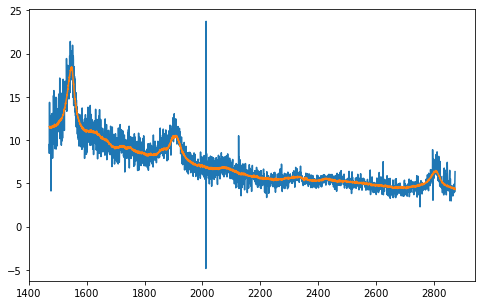

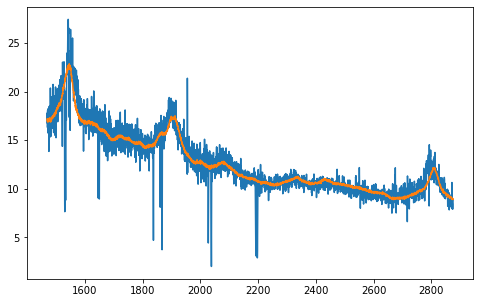

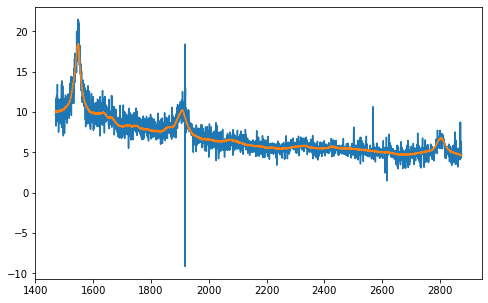

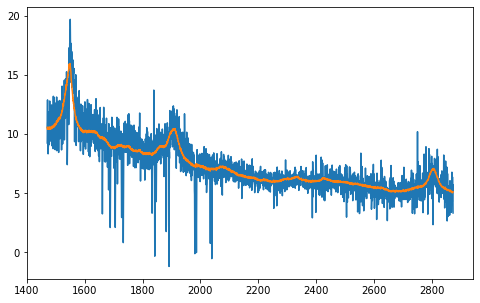

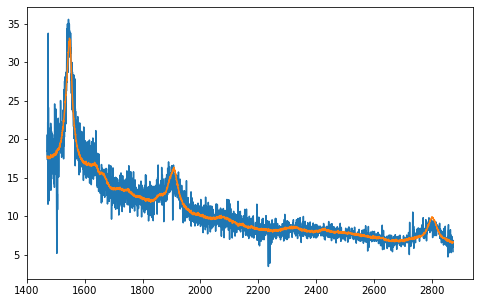

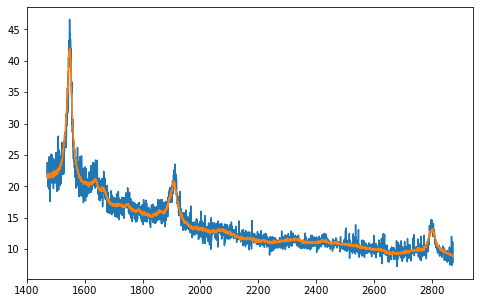

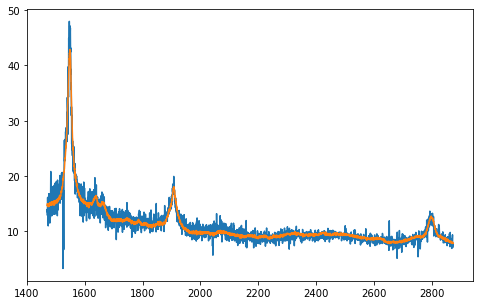

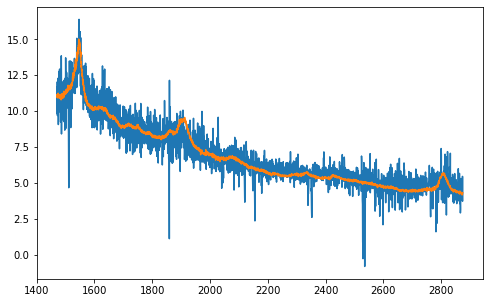

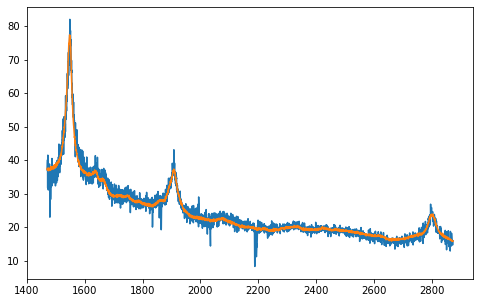

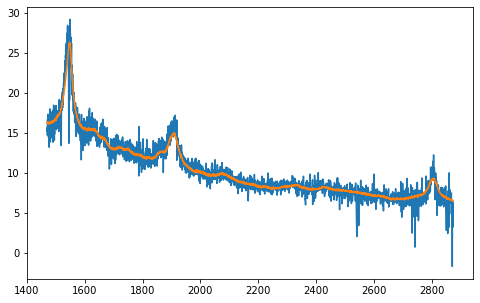

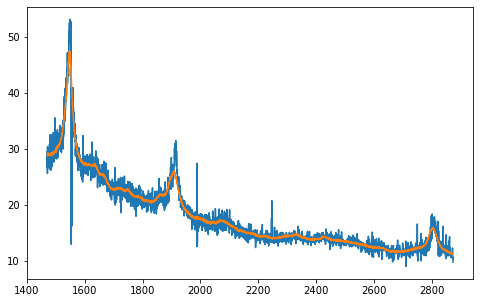

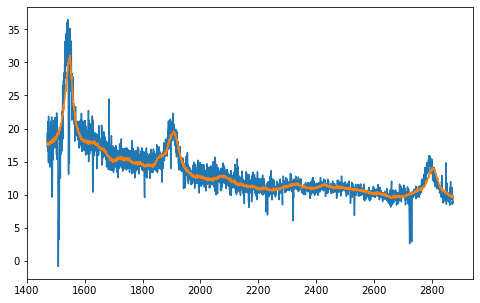

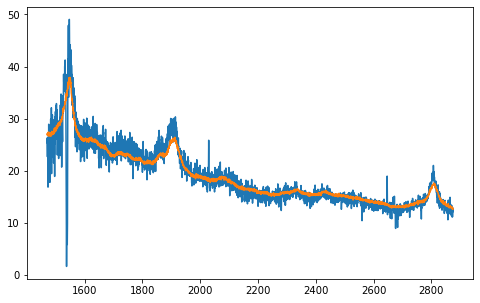

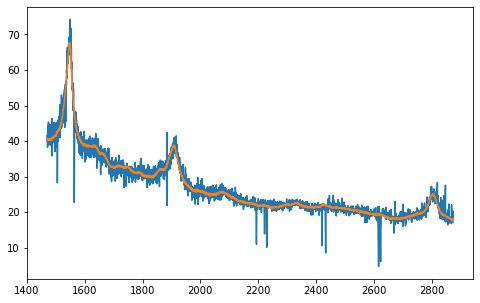

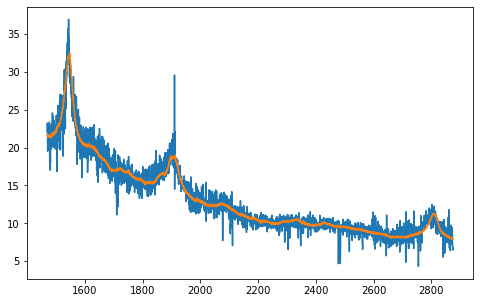

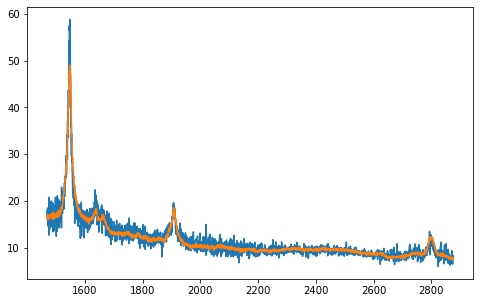

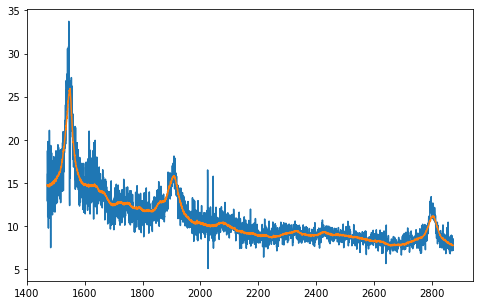

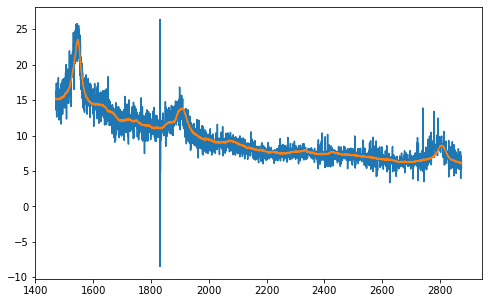

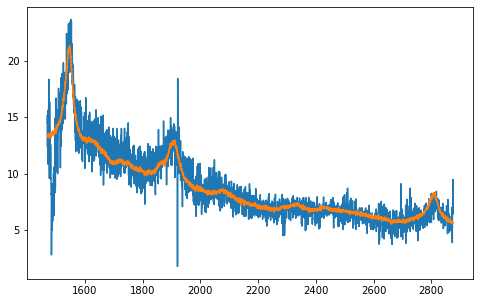

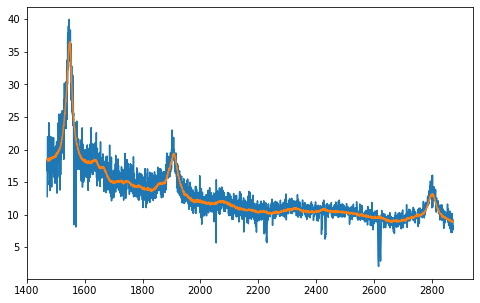

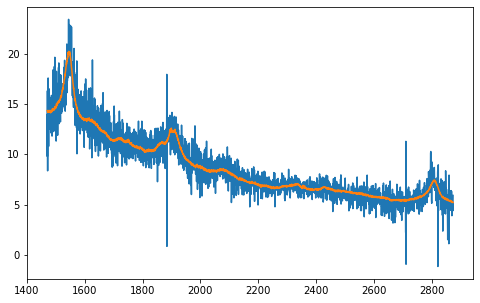

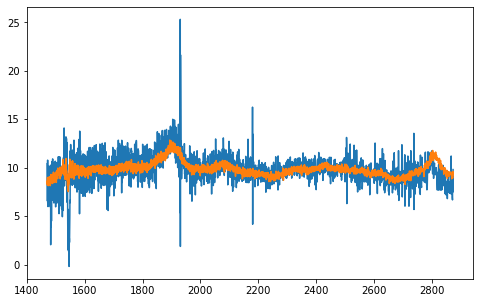

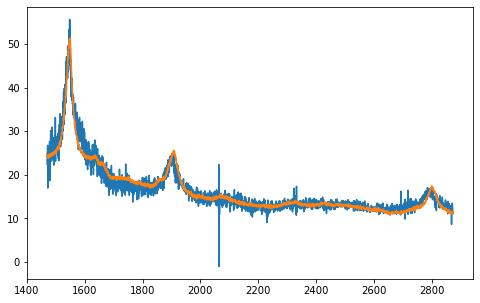

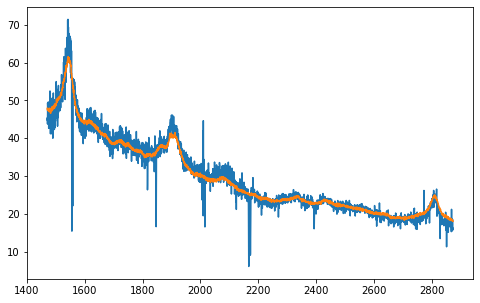

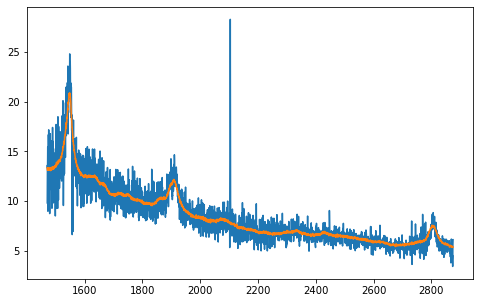

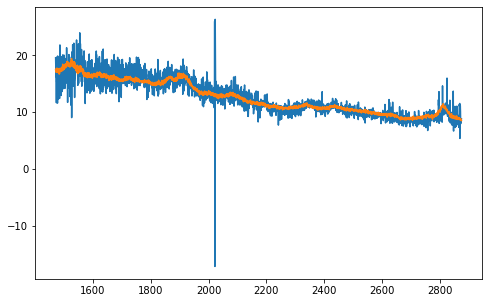

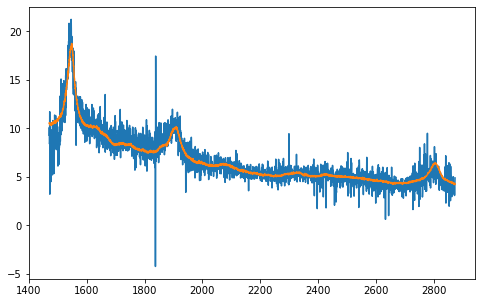

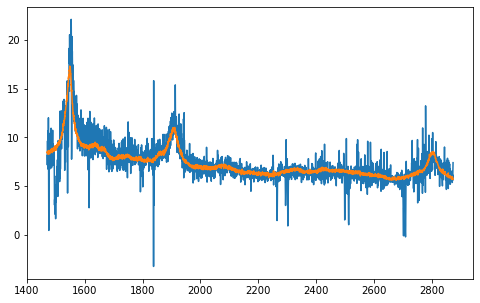

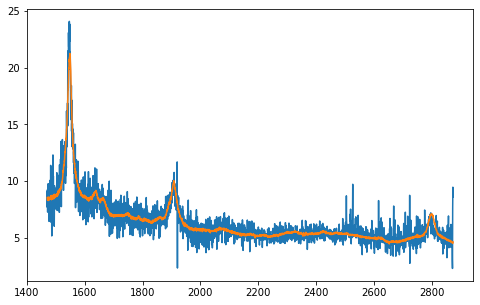

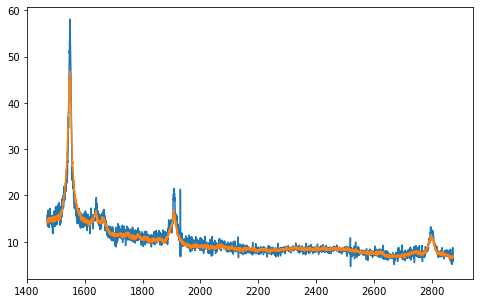

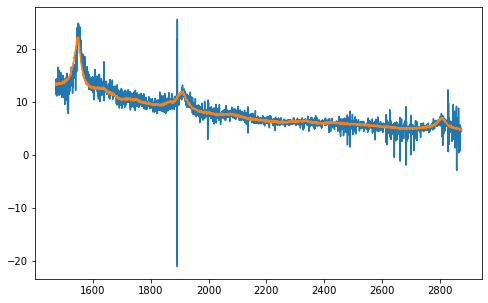

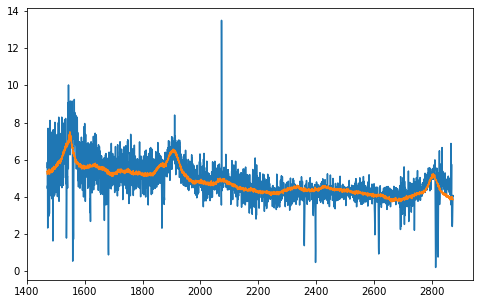

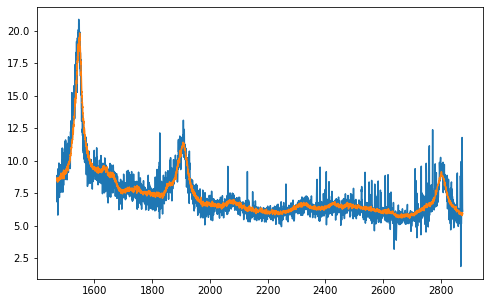

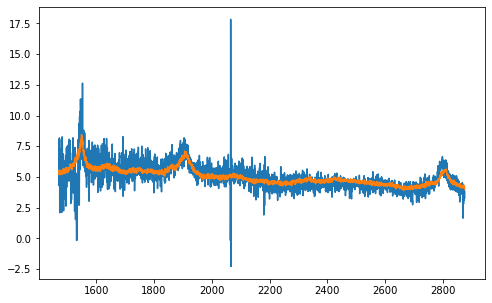

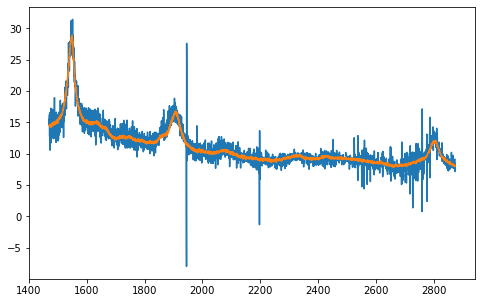

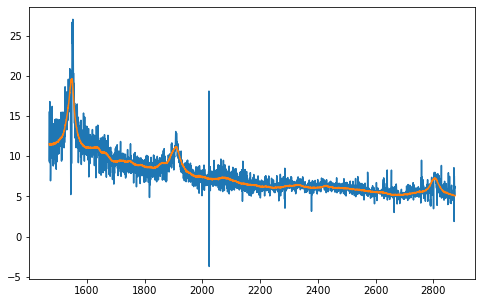

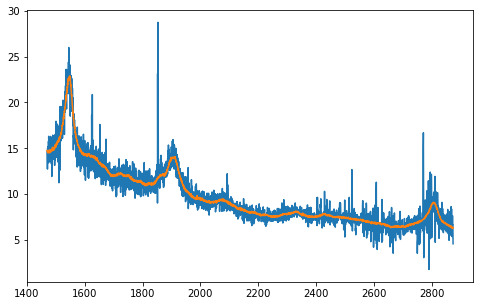

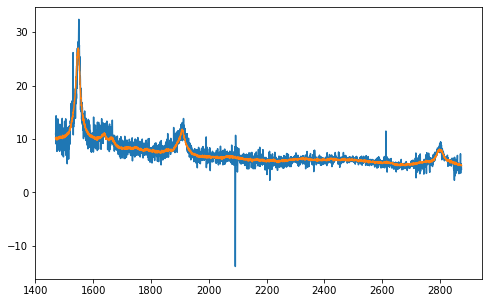

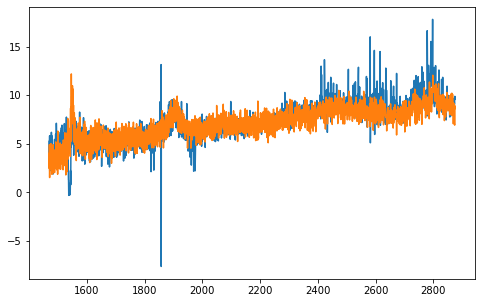

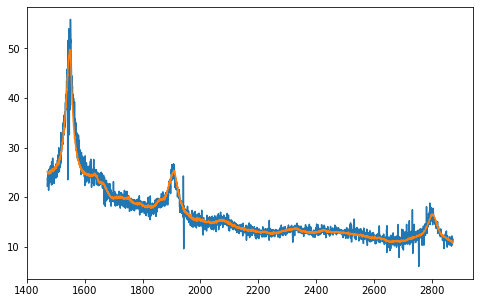

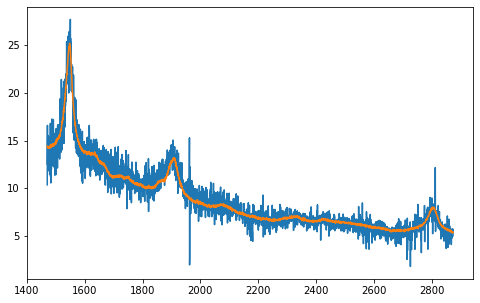

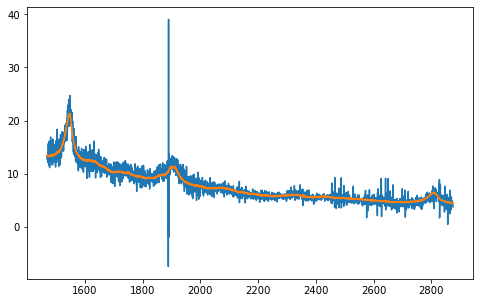

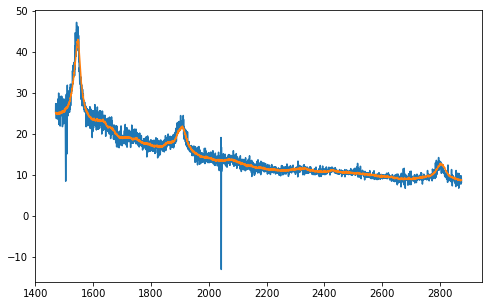

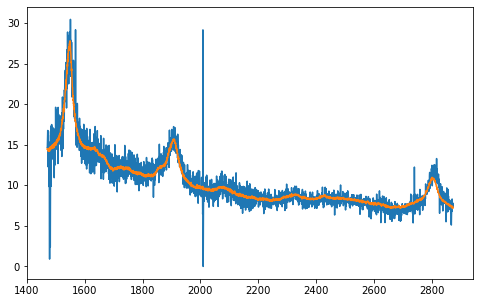

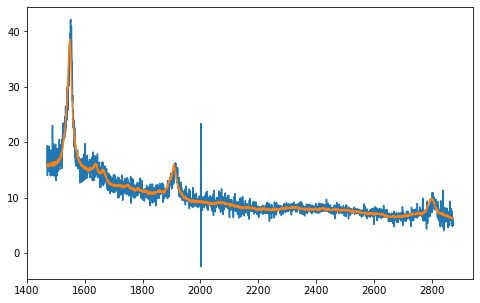

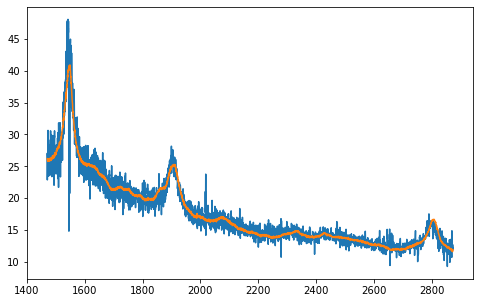

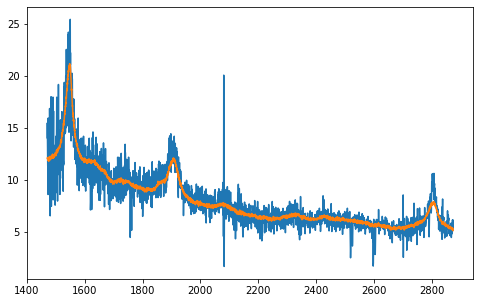

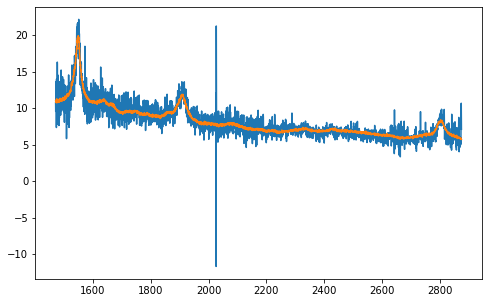

In [458]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[6000+i], X_test[i])
    plt.plot(wave[6000+i], reconst[i])
    plt.show()

Generally pretty good, but definitely weak in some areas.  Stronger emission lines (CIII] and MgII) it seems to struggle with; odd that it seems to sometimes get those spectra right though.  Maybe move to DR14 and get some more spectra now; hopefully more training data will help with some issues.

``Adam`` is definitely the optimizer to use.

In [382]:
X = np.vstack([X_train, X_valid, X_test])
X.shape

(8394, 2913)

In [383]:
#Compress the spectra down to 10 dimensions
X_compressed = stacked_encoder.predict(X)

In [384]:
X_compressed.shape

(8394, 10)

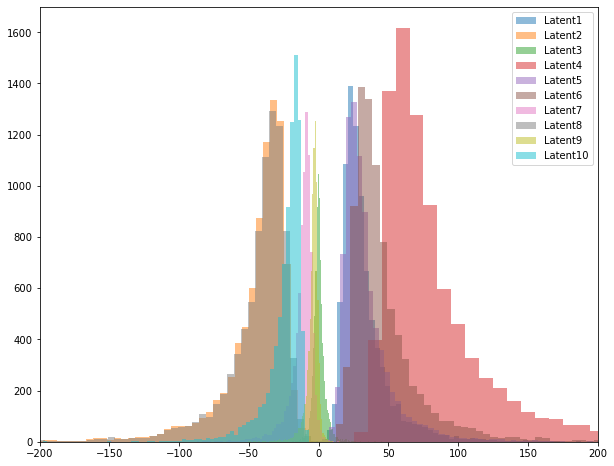

In [391]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.xlim(-200,200)
plt.legend(loc="best")
plt.show()

Note: The SeLU activation function leads to saturation at ~-1.75 for four of the latent parameters; use leaky ReLU to get nice distributions like above.

In [388]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)#,learning_rate=150)
projTSNE2 = tsne.fit_transform(X_compressed)

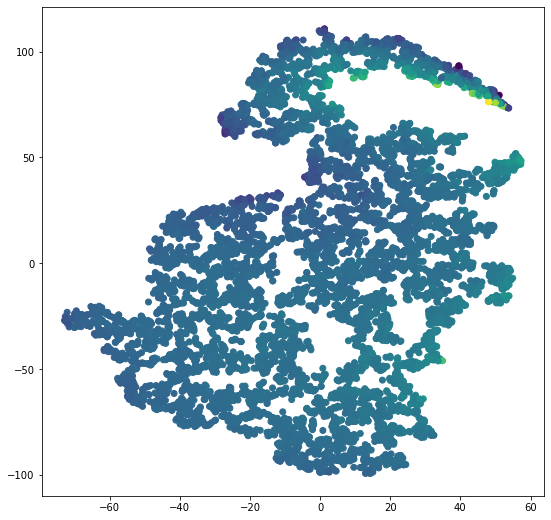

In [453]:
fig = plt.figure(figsize=(9,9))

plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,2])
plt.show()

Interesting... 

Now want to see what exactly each latent parameter represents.  Since we're dealing with 10 parameters, the space created by them is essentially a 10-dimensional hypersphere.  We can track the change caused by one parameter by holding the rest constant (at their median), and changing the value of the given latent parameter incrementally.  Then, after the increment, feed the latent parameters to the decoder and see what information it holds.

One strange (troublesome?) thing is that certain parameters change much more than others, but maybe I should just be running PCA to see which ones to throw out??  (That is, for visualization of just the parameters-- we still need them to reconstruct the spectrum because the decoder needs all)

In [392]:
X_compressed

array([[ 5.8159626e+01, -7.8697647e+01,  1.0583452e+00, ...,
        -7.7381714e+01, -8.4504585e+00, -4.2787975e+01],
       [ 3.5810532e+01, -4.5399807e+01, -5.6031659e-02, ...,
        -4.5233772e+01, -3.6080914e+00, -2.0918337e+01],
       [ 5.3699398e+01, -7.8090630e+01, -1.2625459e+00, ...,
        -7.7149696e+01, -6.2897019e+00, -5.0091805e+01],
       ...,
       [ 2.9969269e+01, -3.9995918e+01, -6.8673599e-01, ...,
        -3.9731594e+01, -1.3135414e+00, -2.1421083e+01],
       [ 1.8161446e+01, -2.3461529e+01,  1.9300592e+00, ...,
        -2.2555178e+01, -3.1697047e+00, -1.2420369e+01],
       [ 1.6572620e+01, -2.2230827e+01, -3.9983231e-01, ...,
        -2.1961082e+01, -1.2562495e+00, -1.1686158e+01]], dtype=float32)

In [393]:
np.median(X_compressed, axis=0)

array([ 2.7754341e+01, -3.7496761e+01, -6.3365102e-02,  7.1086380e+01,
        2.9405085e+01,  3.9423965e+01, -9.9599838e+00, -3.7229012e+01,
       -3.3900146e+00, -2.0131458e+01], dtype=float32)

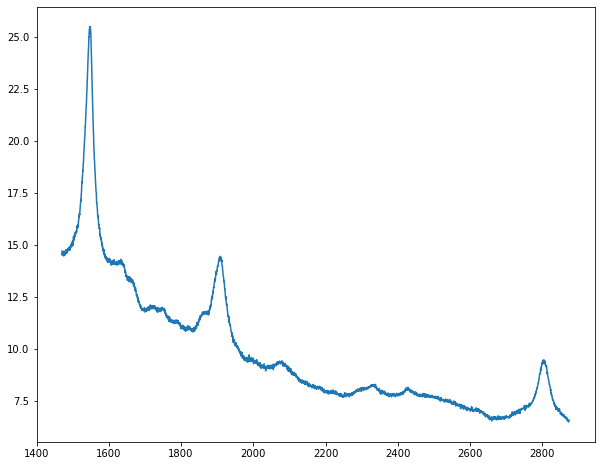

In [394]:
test = stacked_decoder.predict(np.array([np.median(X_compressed, axis=0)]))
fig = plt.figure(figsize=(10,8))
plt.plot(wave[0], test[0])
plt.show()

In [395]:
np.delete(X_compressed[0,:], 1).shape

(9,)

In [396]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = np.min(X_comp[:,n]), min(np.max(X_comp[:,n]), 400)
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [397]:
get_latent(X_compressed, 0, n_diff).shape

(7, 2913)

In [398]:
n_diff = 7
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
predict4 = get_latent(X_compressed, 3, n_diff)
predict5 = get_latent(X_compressed, 4, n_diff)
predict6 = get_latent(X_compressed, 5, n_diff)
predict7 = get_latent(X_compressed, 6, n_diff)
predict8 = get_latent(X_compressed, 7, n_diff)
predict9 = get_latent(X_compressed, 8, n_diff)
predict10= get_latent(X_compressed, 9, n_diff)

In [399]:
predict1[0]

array([18.89772415, 16.35170174, 14.51921368, ..., 10.50765514,
       13.4048481 ,  7.48020029])

In [413]:
def plot_latent(prediction, omit=0, reverse=True):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    plt.legend(loc="best")
    plt.show()

#### Param1

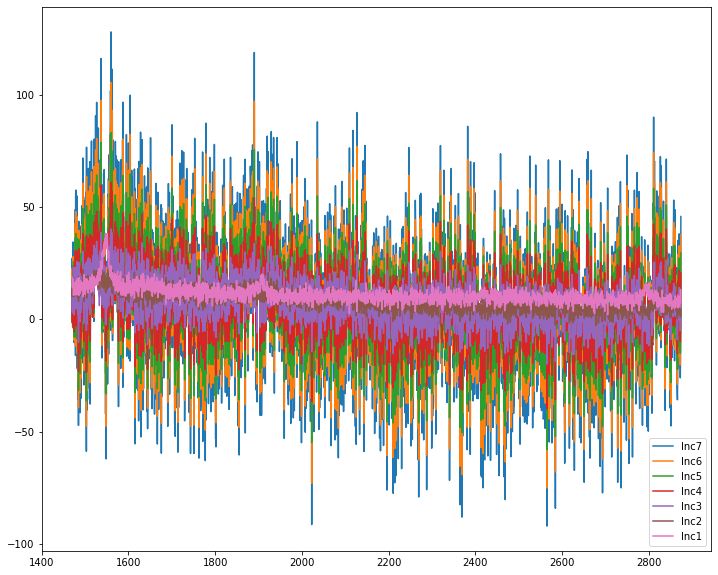

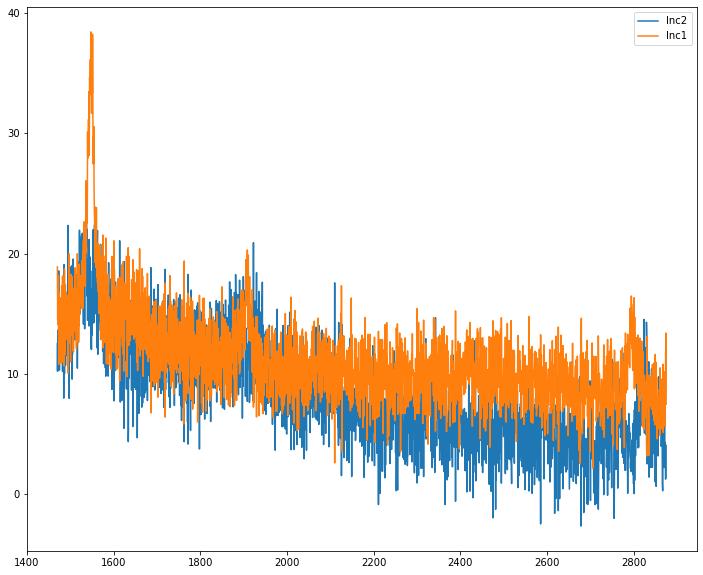

In [414]:
plot_latent(predict1)
plot_latent(predict1, omit=5)

This one just outputs median (the latent parameters are all the ~same...)

#### Param2

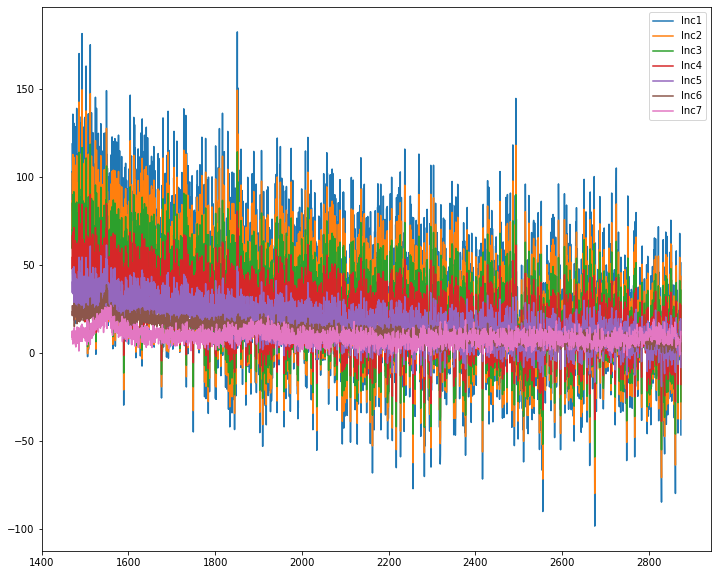

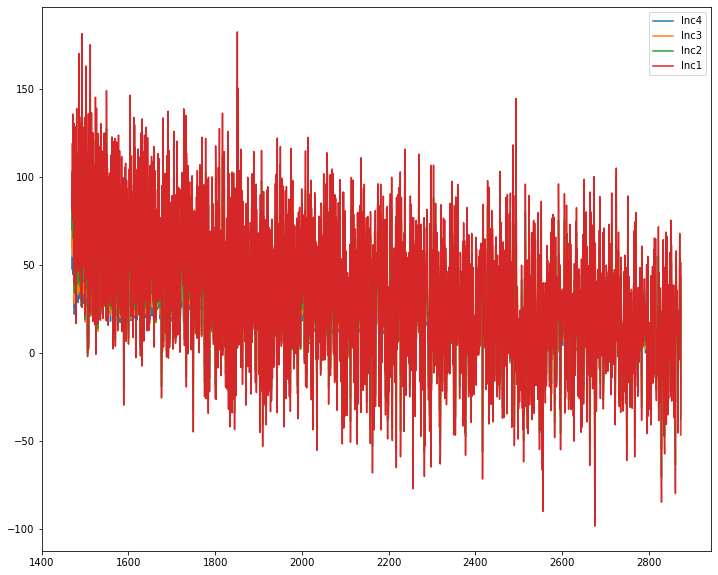

In [415]:
plot_latent(predict2, reverse=False)
plot_latent(predict2, omit=3)

#### Param3

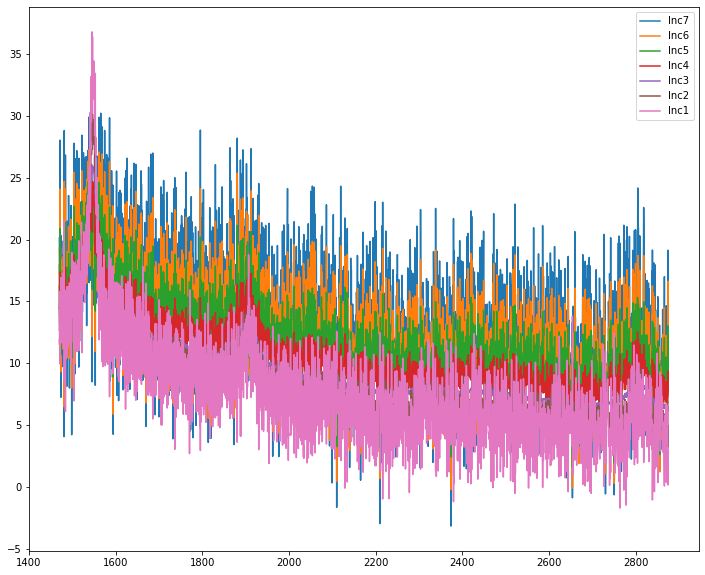

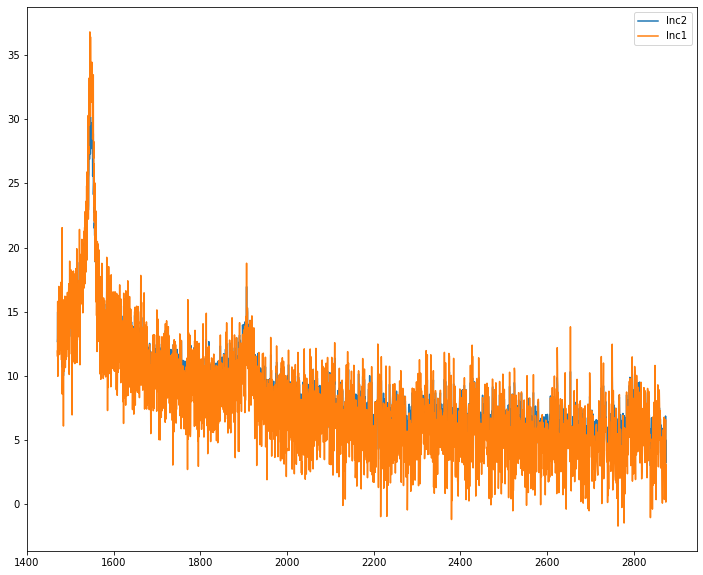

In [416]:
plot_latent(predict3)
plot_latent(predict3, omit=5)


#### Param4

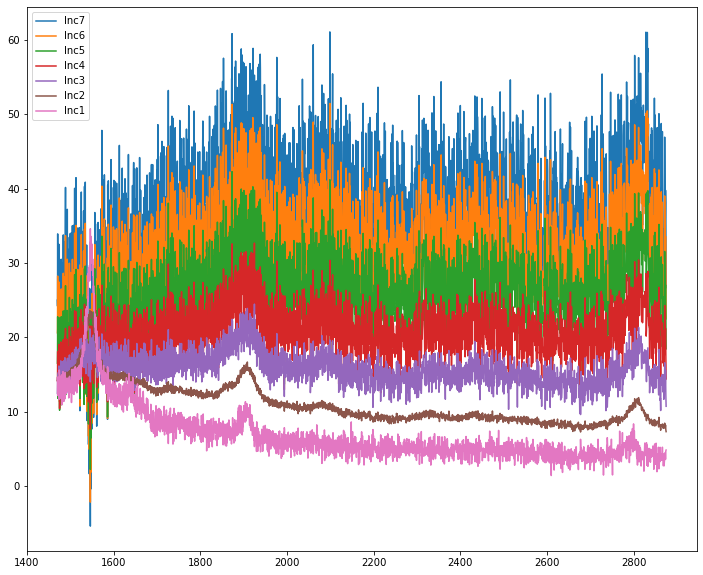

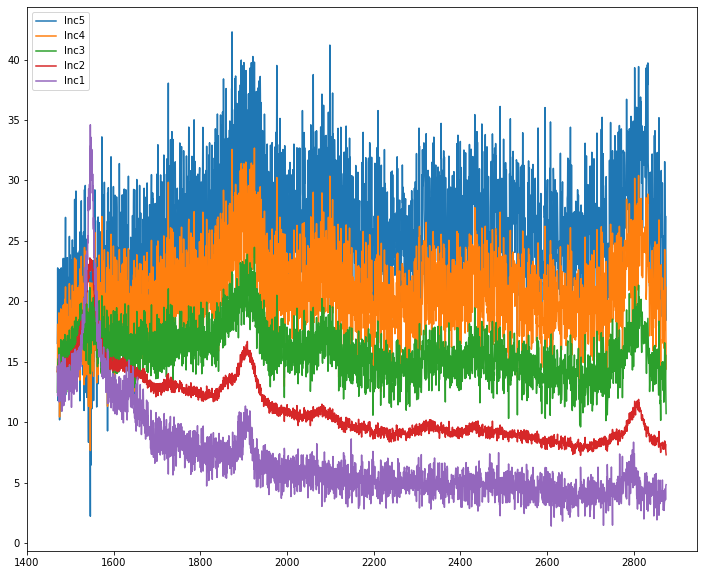

In [417]:
plot_latent(predict4)
plot_latent(predict4, omit=2)

Higher vals tend towards CIV BAL, noisier spectrum

#### Param5

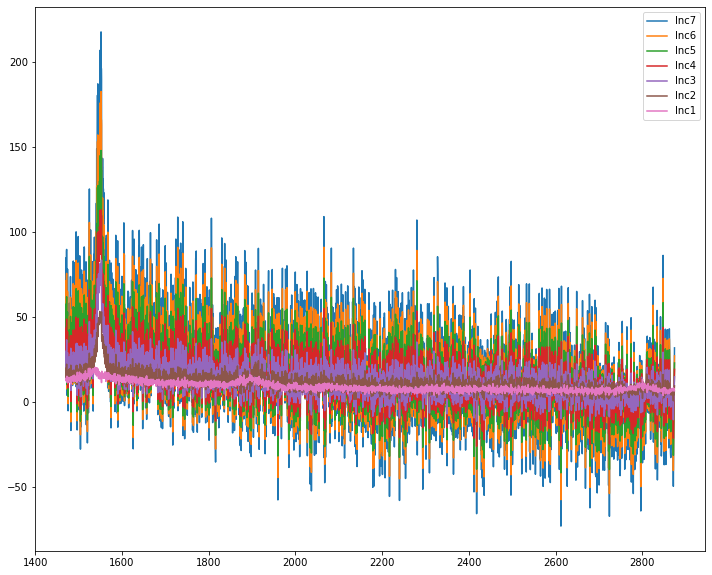

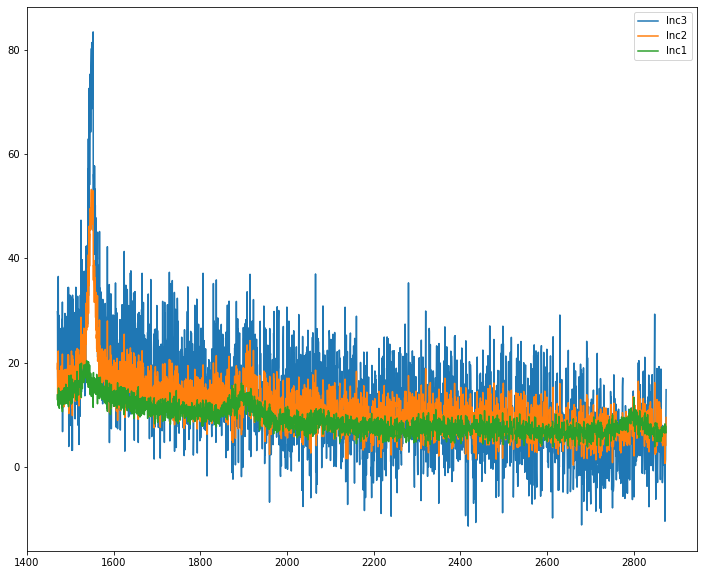

In [418]:
plot_latent(predict5)
plot_latent(predict5, omit=4)

#### Param6

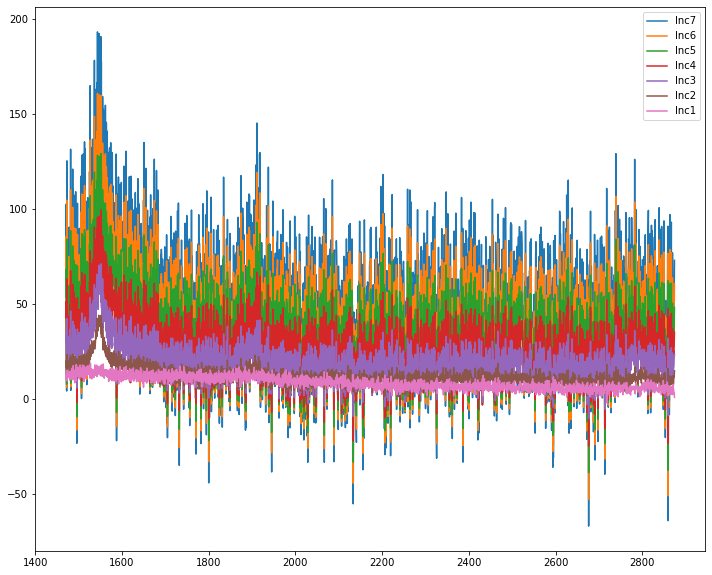

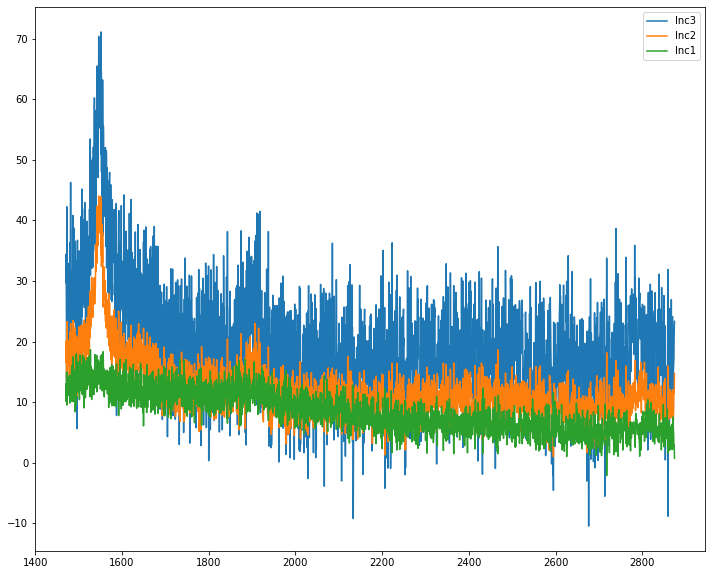

In [419]:
plot_latent(predict6)
plot_latent(predict6, omit=4)

#### Param7

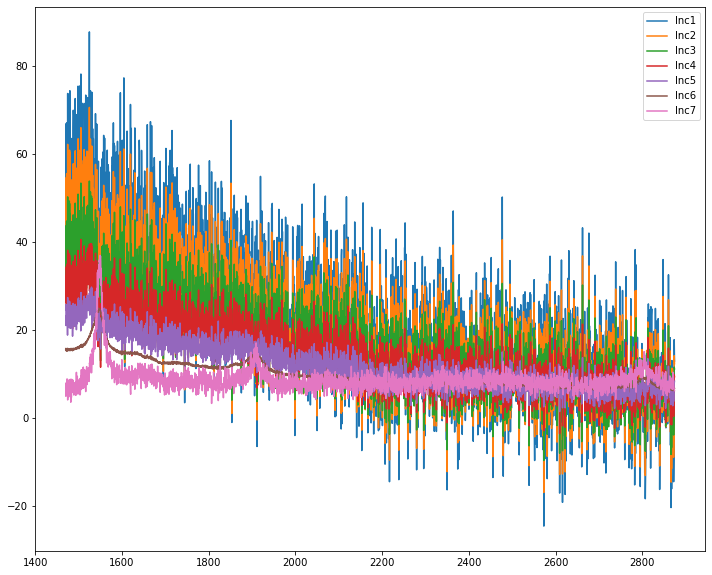

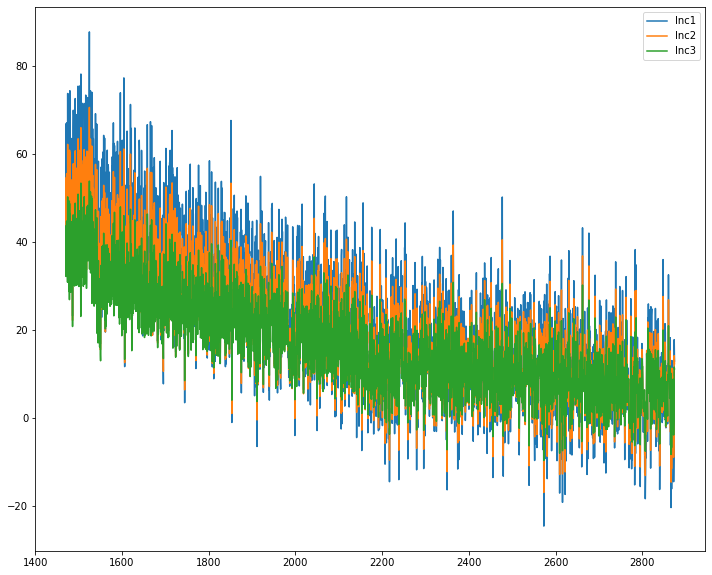

In [422]:
plot_latent(predict7, reverse=False)
plot_latent(predict7, omit=4, reverse=False)

#### Param8

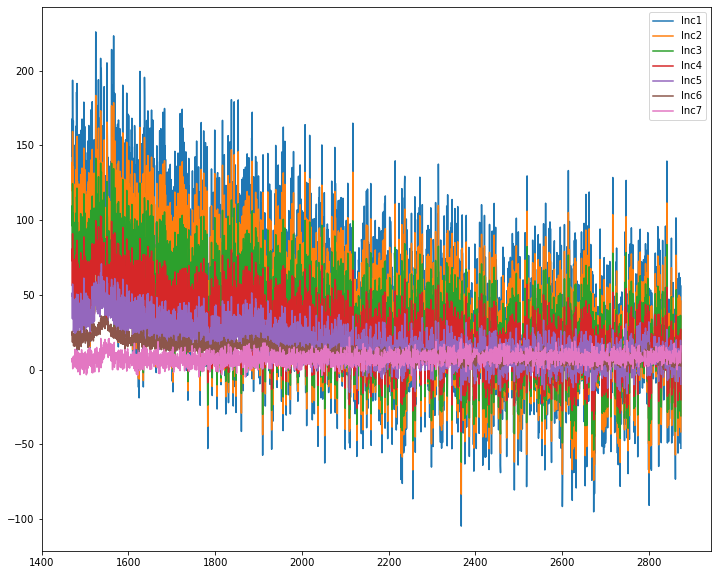

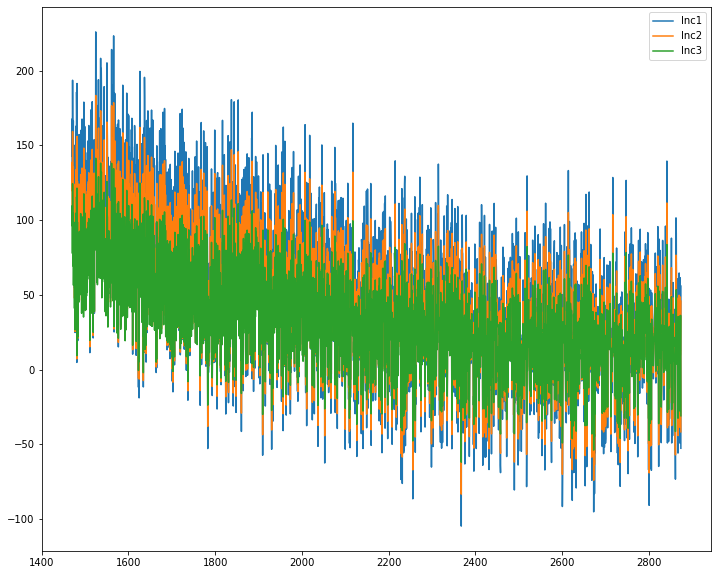

In [425]:
plot_latent(predict8, reverse=False)
plot_latent(predict8, omit=4, reverse=False)

#### Param9

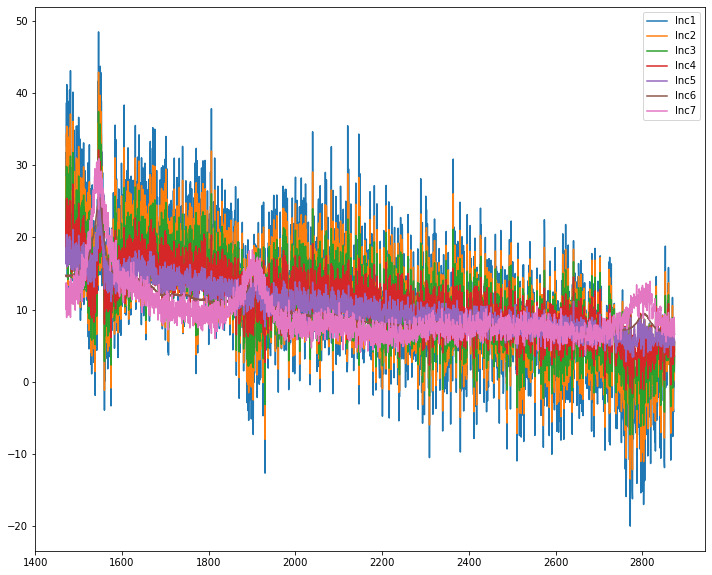

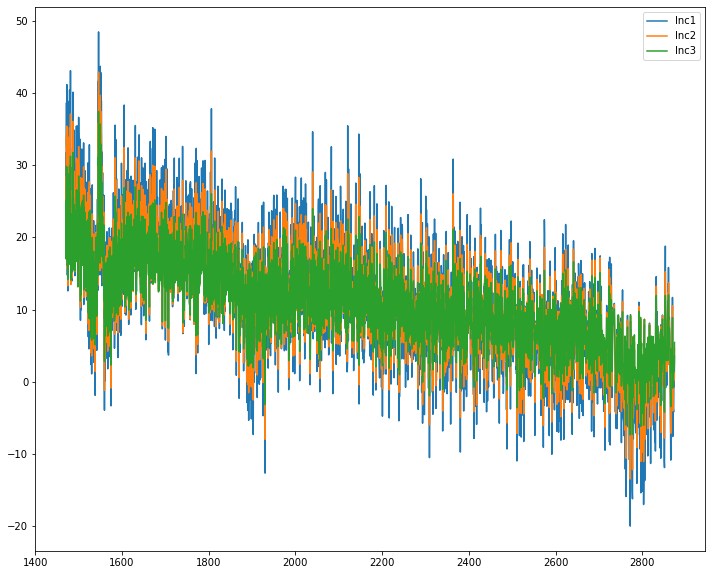

In [427]:
plot_latent(predict9, reverse=False)
plot_latent(predict9, omit=4, reverse=False)

#### Param10

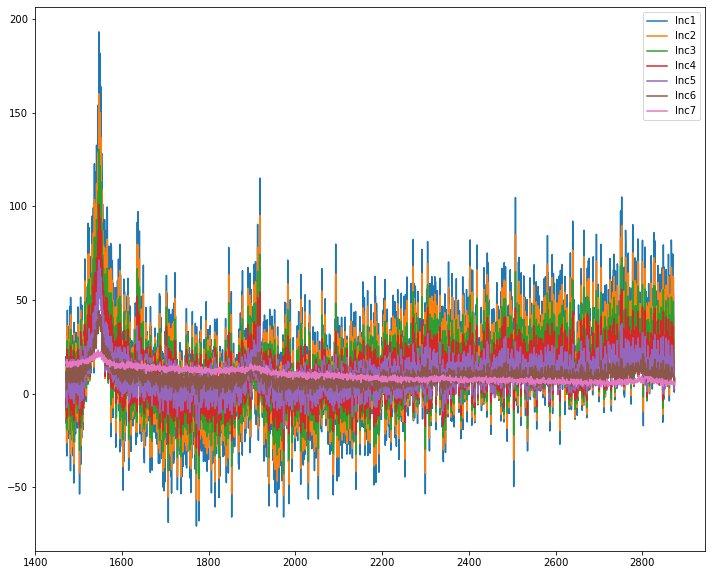

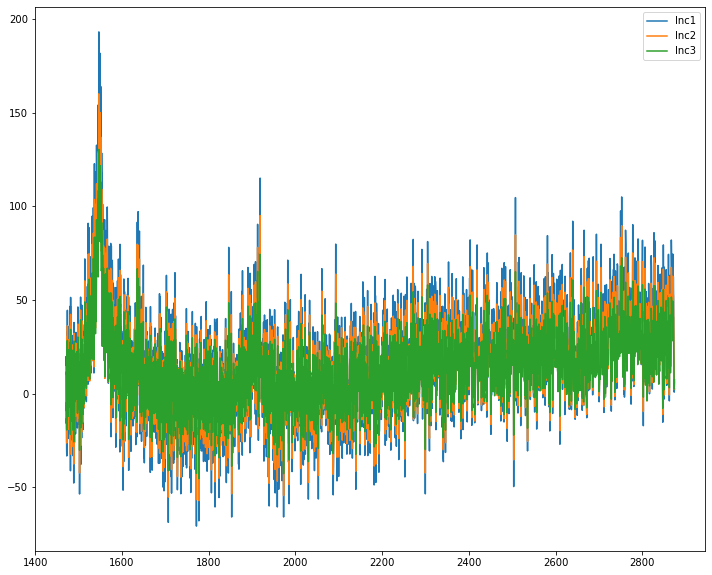

In [430]:
plot_latent(predict10, reverse=False)
plot_latent(predict10, omit=4, reverse=False)

In [454]:
def plotTSNE(colorcode, mask, lab=""):
    fig = plt.figure(figsize=(9,9))
    plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=colorcode, vmin=np.percentile(colorcode, 15), 
                vmax=np.percentile(colorcode, 85), label=lab)
    plt.colorbar()
    plt.legend(loc="best")
    plt.show()

In [437]:
dat.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET      MI_Z2    LOGLBOL  ...  LOGL_MGII    EW_MGII  \
0  51608               0 -27.635967  47.094489  ...  44.376721  26.967853   
1  51633               0 -26.986037  46.849020  ...  44.163982  28.819893   
2  51909               0 -27.539811  47.031922  ...  44.413369  34.569696   
3  51909               0 -26.907112  46.713170  ...  43.993350  26.541603   
4  51883               0 -27.177639  46.782514  ...  44.111600  29.946692   

   LOGL_BROAD_MGII  EW_BROAD_MGII   LOGL_CIV     EW_CIV  VOFF_CIV_PEAK  \
0        44.366029      26.312016  44.901087  36.111955     712.104035   
1        44.132085      26.779087  44.658484  32.642452     305.754876   
2        44.408935      34.218546  44.929561  56.727337     -26.149363   
3        43.989344      26.297896  44.421090  25.101699    1000.490718   
4        44.104876      29.486556  44.499160  28.892388     530.384452   

   LOGEDD_RATIO      Z_HW      E_BV  
0     -0.494012  1.779394  0.069739  
1     -0.837157  1.882529  0.035407  
2     -0.780922  1.668503  0.044319  
3     -0.337591  1.750491  0.031931  
4     -0.564674  1.823599  0.048818  

[5 rows x 25 columns]

In [438]:
len(found)

8394

In [442]:
dat[["LOGLBOL"]].values.flatten()

array([47.09448912, 46.8490198 , 47.03192224, ..., 47.08738135,
       46.77145762, 46.43468484])

In [444]:
np.percentile(dat[["LOGLBOL"]].values.flatten(), 15)

46.588360133665574

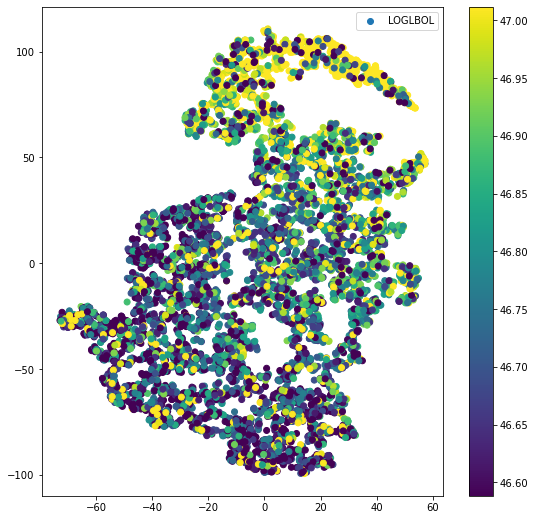

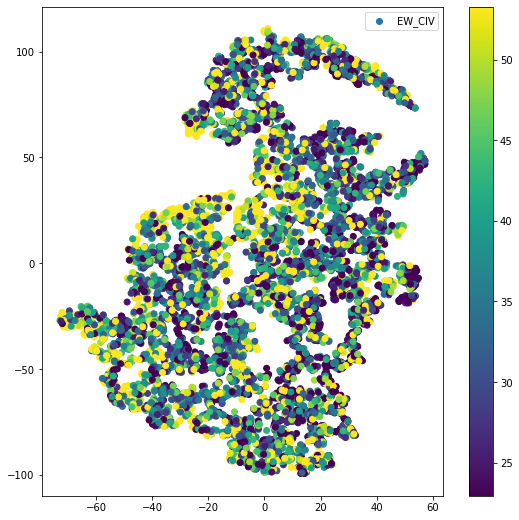

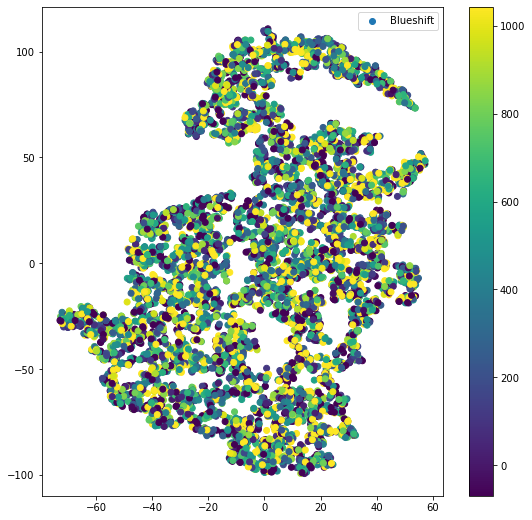

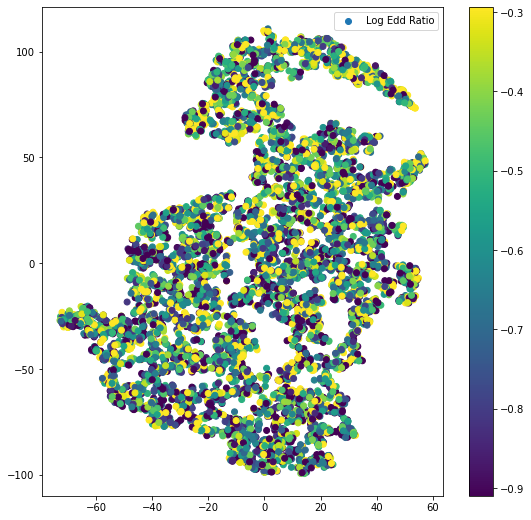

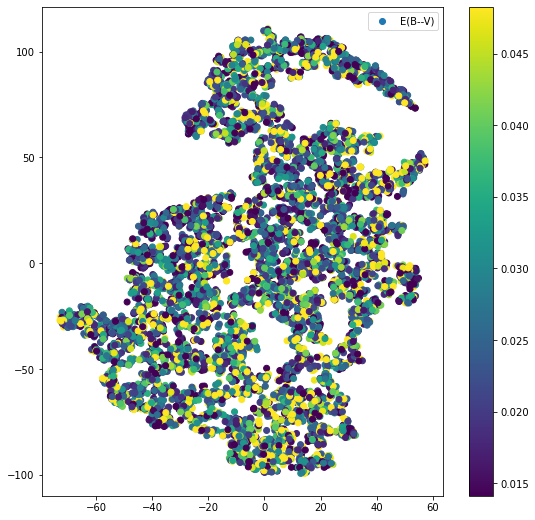

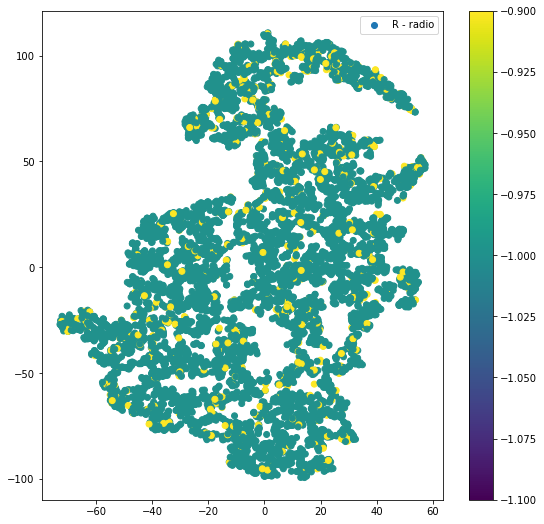

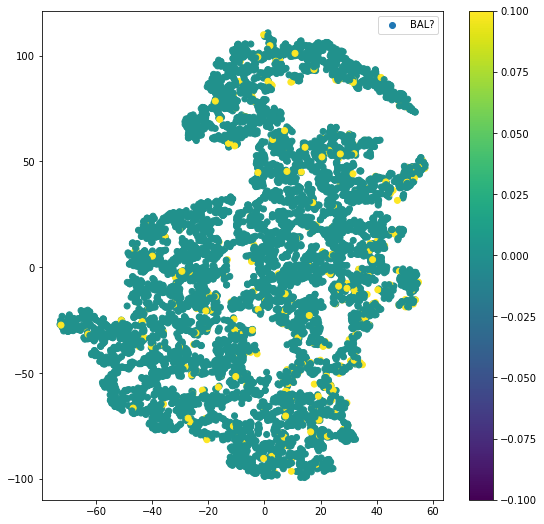

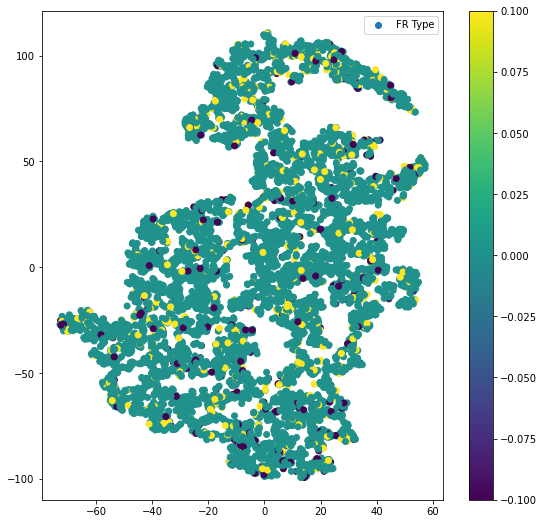

In [456]:
plotTSNE(dat[["LOGLBOL"]].values.flatten()[found.astype(int)], found.astype(int), "LOGLBOL")
plotTSNE(dat[["EW_CIV"]].values.flatten()[found.astype(int)], found.astype(int), "EW_CIV")
plotTSNE(dat[["VOFF_CIV_PEAK"]].values.flatten()[found.astype(int)], found.astype(int), "Blueshift")
plotTSNE(dat[["LOGEDD_RATIO"]].values.flatten()[found.astype(int)], found.astype(int), "Log Edd Ratio")
plotTSNE(dat[["E_BV"]].values.flatten()[found.astype(int)], found.astype(int), "E(B--V)")
plotTSNE(dat[["R_6CM_2500A"]].values.flatten()[found.astype(int)], found.astype(int), "R - radio")
plotTSNE(dat[["BAL_FLAG"]].values.flatten()[found.astype(int)], found.astype(int), "BAL?")
plotTSNE(dat[["FIRST_FR_TYPE"]].values.flatten()[found.astype(int)], found.astype(int), "FR Type")

Maybe objects with high Lbol like to hang in the upper right??

Do PCA and throw out some lower-significance components.  Then t-SNE again.

In [459]:
from sklearn.decomposition import PCA
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

In [460]:
pipe = Pipeline([('scaler', StandardScaler()), #normalizing data
                ('reducer', PCA())])           #dimensionality reduction

pc = pipe.fit_transform(X_compressed)          #data goes here for processing

#Extracting useful metrics
var = pipe.steps[1][1].explained_variance_ratio_
var_sum = pipe.steps[1][1].explained_variance_ratio_.cumsum()

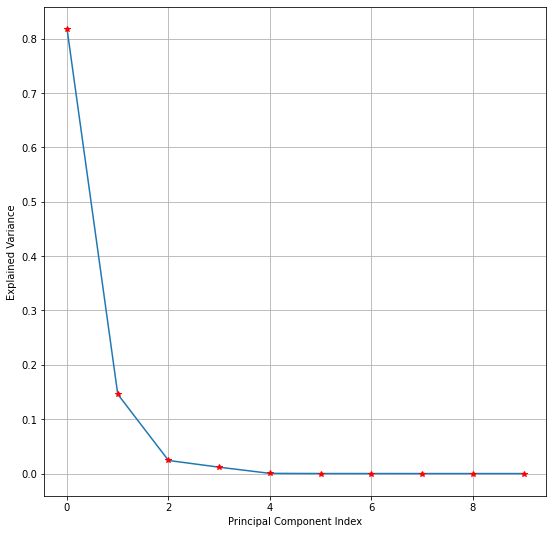

In [461]:
fig = plt.figure(figsize=(9,9))

plt.plot(var)
plt.plot(var,'r*')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

Did PCA order the features for me??  Maybe don't want this.

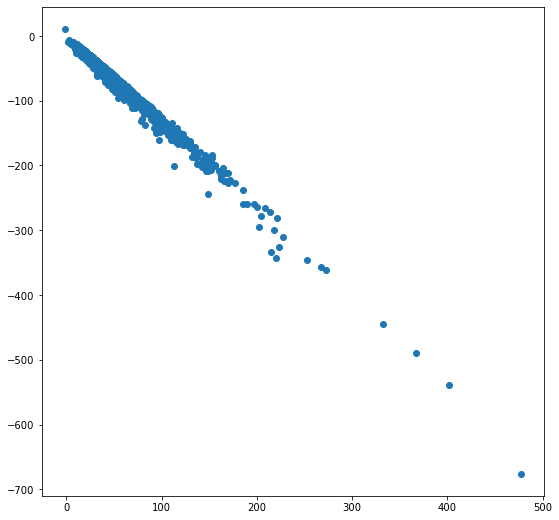

In [469]:
fig = plt.figure(figsize=(9,9))
plt.scatter(X_compressed[:,0], X_compressed[:,1])
plt.show()

In [467]:
pd.DataFrame(X_compressed)

0          1         2           3          4          5  \
0     58.159626 -78.697647  1.058345  151.287308  60.538883  82.504402   
1     35.810532 -45.399807 -0.056032   82.877853  33.965282  47.155083   
2     53.699398 -78.090630 -1.262546  150.277481  64.447052  84.716866   
3     32.895260 -42.436310 -0.792538   79.003944  32.079586  44.239746   
4     28.294979 -37.402653  1.008916   76.533455  28.192621  39.322639   
...         ...        ...       ...         ...        ...        ...   
8389  11.650945 -16.556259  0.307884   31.239450  13.031927  17.065111   
8390  19.609247 -27.861830 -5.180634   40.643890  24.006140  30.085058   
8391  29.969269 -39.995918 -0.686736   78.334579  31.746330  42.959785   
8392  18.161446 -23.461529  1.930059   50.700264  17.236481  24.766420   
8393  16.572620 -22.230827 -0.399832   41.502922  17.273977  23.561424   

              6          7         8          9  
0    -22.001825 -77.381714 -8.450459 -42.787975  
1    -15.498112 -45.233772 -3.608091 -20.918337  
2    -14.044451 -77.149696 -6.289702 -50.091805  
3    -13.325390 -42.080982 -2.139222 -19.725451  
4    -12.563434 -36.463459 -3.581268 -19.532099  
...         ...        ...       ...        ...  
8389  -3.825672 -16.419161 -2.672583  -9.678017  
8390  -2.141521 -29.310846  2.509856 -15.081025  
8391 -10.403521 -39.731594 -1.313541 -21.421083  
8392  -9.232823 -22.555178 -3.169705 -12.420369  
8393  -6.122701 -21.961082 -1.256250 -11.686158  

[8394 rows x 10 columns]

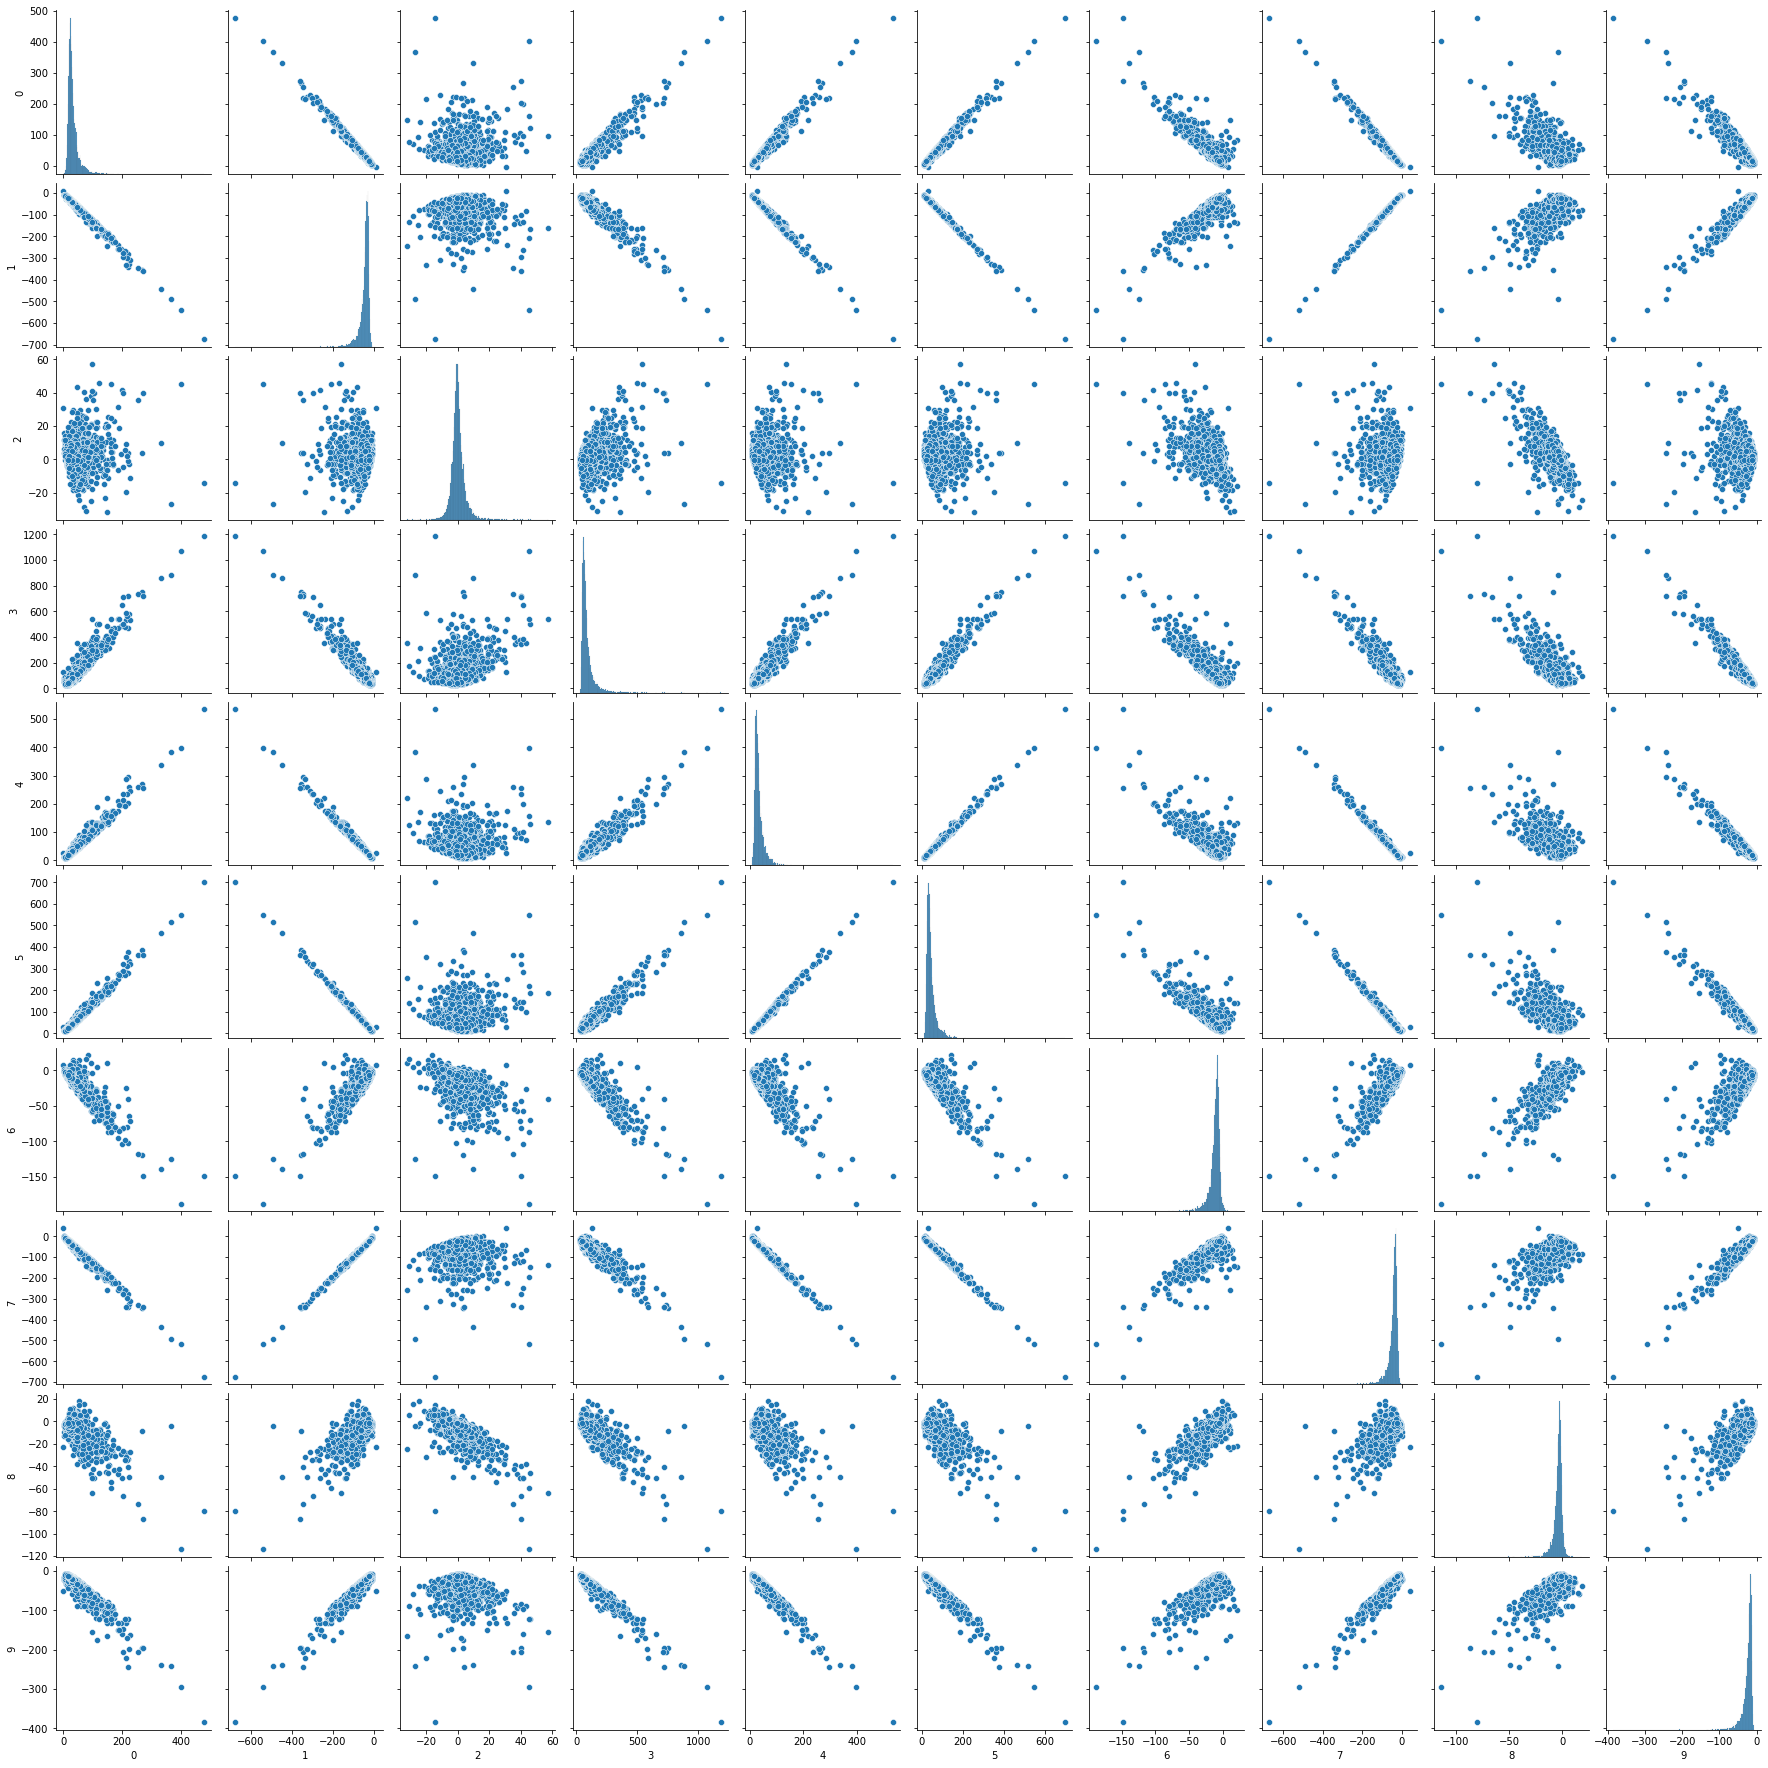

In [468]:
import seaborn

df = pd.DataFrame(X_compressed)

seaborn.pairplot(df)

Take a break for now, but maybe we don't need 10 latent parameters?  

In [470]:
stacked_encoder.save("networks/encoder2.h5")
stacked_decoder.save("networks/decoder2.h5")